## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [3]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [4]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')
adh_data = pd.read_csv('/content/data/adh.csv')

In [5]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
adh_info = ['synced_fitbit', 'checked_weight',	'did_survey',	'fb_streak',
            'bt_streak',	'surv_streak', 'above_min_thresh',
            'percent_of_day_worn',	'above_thresh']

In [6]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)
full_fb_data[target_col] = full_fb_data[target_col].fillna(0)

In [7]:
full_fb_data['has_visit'] = 0

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group[target_col].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [8]:
def zscore_userwise(df, features):
    df_z = df.copy()
    for col in features:
        means = df.groupby('fitbit_user_id')[col].transform('mean')
        stds  = df.groupby('fitbit_user_id')[col].transform('std')
        df_z[col + '_z'] = (df[col] - means) / stds
    return df_z

In [9]:
def zscore_rolling(df, features, bootstrap_n=3):
    df_z = df.copy()

    for col in features:
        df_z[col + '_z'] = np.nan

        for user_id, group in df.groupby('fitbit_user_id'):
            series = group[col]
            z = []
            past_vals = []

            # First phase: collect the first 3 non-NaN values
            idxs = series.index.tolist()
            collected = 0

            for idx in idxs:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                else:
                    past_vals.append(val)
                    collected += 1
                    z.append(None)  # placeholder to be replaced later

                if collected == bootstrap_n:
                    break

            # If we got enough to bootstrap, calculate mean/std and assign z-scores
            if len(past_vals) == bootstrap_n:
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_vals = [(v - mean) / std if std > 0 else 0 for v in past_vals]

                # Replace placeholders
                for i in range(len(z)):
                    if z[i] is None:
                        z[i] = z_vals.pop(0)

            # Continue with the rest
            for idx in idxs[len(z):]:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                    continue

                past_vals.append(val)
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_val = (val - mean) / std if std > 0 else 0
                z.append(z_val)

            df_z.loc[series.index, col + '_z'] = z

    return df_z


In [10]:
z_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd']

z_fb_data = zscore_rolling(full_fb_data, z_features)

/tmp/ipython-input-9-4060948298.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[None, None, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [11]:
def extract_days_before_visit(df, days_before=14):
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Slice window before visit
        visit_window = group[(group['days'] >= visit_day - days_before) & (group['days'] <= visit_day)].copy()

        # Add relative day to visit
        visit_window['days_to_visit'] = visit_window['days'] - visit_day
        visit_window['fitbit_user_id'] = user_id

        output_rows.append(visit_window)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [12]:
def extract_days_no_visits(df, window_days=15, max_windows=3, seed=42):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 0].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [13]:
two_week_visit = extract_days_before_visit(z_fb_data)
three_week_visit = extract_days_before_visit(z_fb_data, days_before=21)
two_week = extract_days_no_visits(z_fb_data)
three_week = extract_days_no_visits(z_fb_data, window_days=22)

In [235]:
three_week_visit

Unnamed: 0       date study_group  fitbit_user_id  avgWeight_per_day  \
0            900 2021-08-10   App Money               7         123.789413   
1            901 2021-08-11   App Money               7         207.454742   
2            902 2021-08-12   App Money               7                NaN   
3            903 2021-08-13   App Money               7                NaN   
4            904 2021-08-14   App Money               7                NaN   
...          ...        ...         ...             ...                ...   
1043       41628 2024-07-03   App Money             284         245.594668   
1044       41629 2024-07-04   App Money             284         241.846814   
1045       41630 2024-07-05   App Money             284         242.287738   
1046       41631 2024-07-06   App Money             284         242.949124   
1047       41632 2024-07-07   App Money             284         241.626352   

      calories  heart   steps  diet  medication  ...  percent_of_day_worn  \
0       2342.0  103.0  3921.0   NaN         NaN  ...             0.777778   
1       2142.0   99.0  2152.0   NaN         NaN  ...             0.568056   
2       2407.0  100.0  3607.0   NaN         NaN  ...             0.512500   
3       2671.0    NaN  5306.0   NaN         NaN  ...             0.910417   
4       2458.0  100.0  4340.0   NaN         NaN  ...             0.780556   
...        ...    ...     ...   ...         ...  ...                  ...   
1043    2120.0   72.0  1165.0   1.0         2.0  ...             0.745833   
1044    2342.0   74.0  1559.0   1.0         2.0  ...             0.863194   
1045    2214.0   75.0  1777.0   1.0         2.0  ...             0.685417   
1046    2339.0   75.0  1760.0   1.0         2.0  ...             0.831250   
1047    2584.0   76.0  2694.0   1.0         2.0  ...             1.000000   

      above_thresh  has_visit  avgWeight_per_day_z calories_z   heart_z  \
0                1          1            -1.131697   0.325822  1.120897   
1                1          1             0.764458  -1.122275 -0.800641   
2                1          1                  NaN   0.796453 -0.320256   
3                1          1                  NaN   1.284514       NaN   
4                1          1                  NaN   0.281972 -0.288675   
...            ...        ...                  ...        ...       ...   
1043             1          1            -2.148255  -1.020837  0.201844   
1044             1          1            -3.134266   0.316502  1.471262   
1045             1          1            -2.718668  -0.458317  2.013027   
1046             1          1            -2.343012   0.306539  1.919145   
1047             1          1            -2.533171   1.753227  2.366245   

       steps_z  hrv_dailyRmssd_z  hrv_deepRmssd_z  days_to_visit  
0     0.735649               NaN              NaN            -21  
1    -1.138613               NaN              NaN            -20  
2     0.402965               NaN              NaN            -19  
3     1.205049               NaN              NaN            -18  
4      0.41224               NaN              NaN            -17  
...        ...               ...              ...            ...  
1043 -1.223332          0.514629        -0.113195             -4  
1044 -0.557534               NaN              NaN             -3  
1045 -0.188738               NaN              NaN             -2  
1046 -0.215467               NaN              NaN             -1  
1047  1.349231               NaN              NaN              0  

[1048 rows x 53 columns]

In [15]:
def extract_random_days_before_visit(df, days_before=15, max_windows=3, seed=42, exclude_window_before_visit=False):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 1].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue

        first_visit_day = group.loc[visit_indices[0], 'days']

        # Define max allowable end day based on flag
        if exclude_window_before_visit:
            max_end_day = first_visit_day - days_before  # force entire window before visit window
        else:
            max_end_day = first_visit_day  # allow any window before visit

        min_day = group['days'].min()
        max_start_day = max_end_day - days_before

        if max_start_day < min_day:
            continue  # not enough room for even one window

        possible_starts = list(range(min_day, max_start_day + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start_day in possible_starts:
            end_day = start_day + days_before
            window = group[(group['days'] >= start_day) & (group['days'] < end_day)].copy()

            if len(window) == days_before:
                # Align to end of window like other no-visit functions
                window['days_to_window'] = window['days'] - (end_day - 1)
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)


In [16]:
two_week_visit_random = extract_random_days_before_visit(z_fb_data)
three_week_visit_random = extract_random_days_before_visit(z_fb_data, days_before=22)
two_week_visit_random_window = extract_random_days_before_visit(z_fb_data, exclude_window_before_visit=True)
three_week_visit_random_window = extract_random_days_before_visit(z_fb_data, days_before=22, exclude_window_before_visit=True)

In [108]:
three_week_visit_random_window

Unnamed: 0       date study_group  fitbit_user_id  avgWeight_per_day  \
0           2551 2021-10-29      No App              19                NaN   
1           2552 2021-10-30      No App              19                NaN   
2           2553 2021-10-31      No App              19                NaN   
3           2554 2021-11-01      No App              19         181.881150   
4           2555 2021-11-02      No App              19                NaN   
...          ...        ...         ...             ...                ...   
2371       41603 2024-06-08   App Money             284         252.428990   
2372       41604 2024-06-09   App Money             284         252.869914   
2373       41605 2024-06-10   App Money             284         252.208528   
2374       41606 2024-06-11   App Money             284         251.767604   
2375       41607 2024-06-12   App Money             284         251.547142   

      calories  heart   steps  diet  medication  ...  percent_of_day_worn  \
0       1304.0    NaN     0.0   NaN         NaN  ...             0.000000   
1       1304.0    NaN     0.0   NaN         NaN  ...             0.000000   
2       1303.0    NaN     0.0   NaN         NaN  ...             0.000000   
3       1304.0    NaN     0.0   NaN         NaN  ...             0.000000   
4       1303.0    NaN     0.0   NaN         NaN  ...             0.000000   
...        ...    ...     ...   ...         ...  ...                  ...   
2371    2143.0   72.0  1203.0   1.0         2.0  ...             0.784028   
2372    2249.0   72.0  1524.0   1.0         2.0  ...             1.000000   
2373    2190.0   72.0  1031.0   1.0         2.0  ...             0.704861   
2374    2185.0   74.0  1526.0   1.0         2.0  ...             0.775000   
2375    2274.0   75.0  1519.0   1.0         2.0  ...             0.887500   

      above_thresh  has_visit  avgWeight_per_day_z calories_z   heart_z  \
0                0          1                  NaN  -0.462716       NaN   
1                0          1                  NaN  -0.454355       NaN   
2                0          1                  NaN  -0.458975       NaN   
3                0          1             0.090321  -0.438462       NaN   
4                0          1                  NaN  -0.444196       NaN   
...            ...        ...                  ...        ...       ...   
2371             1          1             0.471952  -1.119119 -0.127448   
2372             1          1             0.591306  -0.495542 -0.124939   
2373             1          1             0.376745  -0.814003 -0.122573   
2374             1          1             0.232305  -0.817203  1.387777   
2375             1          1             0.158161  -0.283858  1.966234   

       steps_z  hrv_dailyRmssd_z  hrv_deepRmssd_z  days_to_window  
0    -0.346593               NaN              NaN             -21  
1    -0.340828               NaN              NaN             -20  
2    -0.335343               NaN              NaN             -19  
3    -0.330115               NaN              NaN             -18  
4    -0.325124               NaN              NaN             -17  
...        ...               ...              ...             ...  
2371 -1.428574         -0.653449         -0.68301              -4  
2372 -0.805143               NaN              NaN              -3  
2373 -1.601431         -0.463956         -0.04408              -2  
2374 -0.689629         -1.299507        -0.202151              -1  
2375 -0.683964               NaN              NaN               0  

[2376 rows x 53 columns]

## 2) Graphing

In [217]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [209]:
def plot_feature_comparison_3(df1, df2, df3, feature, time_col1='days_to_visit', time_col2='days_to_window', time_col3='days_to_window', label1='Visit Users', label2='No-Visit Users', label3='Random Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(18, 6))

    # Group by time and compute mean# Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    grouped3 = df3.groupby(time_col3)[feature]
    avg3 = grouped3.mean()
    std3 = grouped3.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    x3 = avg3.index.values
    y3 = avg3.values.astype(float)
    std3_vals = std3.reindex(avg3.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.plot(x3, y3, marker='o', label=label3)
    ax.fill_between(x3, y3 - std3_vals, y3 + std3_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)
    ct3 = prepare_for_stacked(df3, time_col3)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")

    ct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Counts")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)
    pct3 = ct3.div(ct3.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    pct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Percentages")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [248]:
def plot_individual_trajectories(df, feature, time_col='days_to_visit'):
    plt.figure(figsize=(12, 6))

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.sort_values(time_col)
        x = group[time_col]
        y = group[feature]

        plt.plot(x, y, alpha=0.5)

        # Label at the last day (day 0 or closest)
        if not x.empty and not y.empty:
            label_x = x.max()
            label_y = y[x.idxmax()]
            plt.text(label_x + 0.3, label_y, str(user_id), fontsize=8, alpha=0.7)

    plt.axvline(0, color='red', linestyle='--', label='Visit Day')
    plt.title(f'Individual Values of {feature} (Visit Users)')
    plt.xlabel('Days to Visit')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

### 2a) Three Week

In [218]:
three_week_visit_weight = drop_nan_user(three_week_visit, 'avgWeight_per_day_z')
three_week_weight = drop_nan_user(three_week, 'avgWeight_per_day_z')

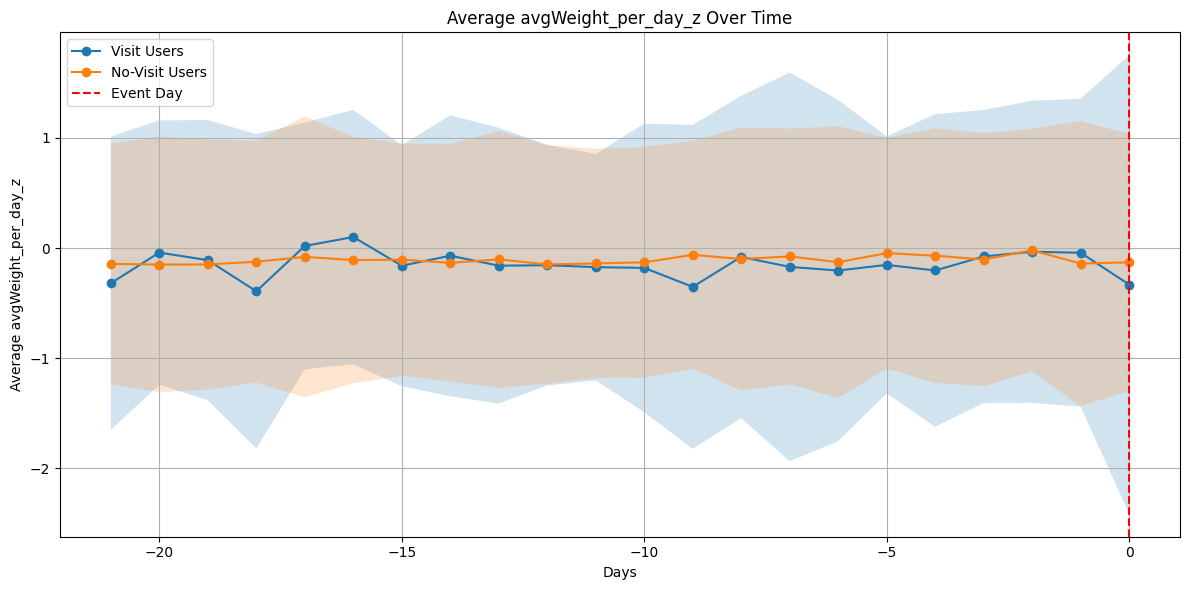

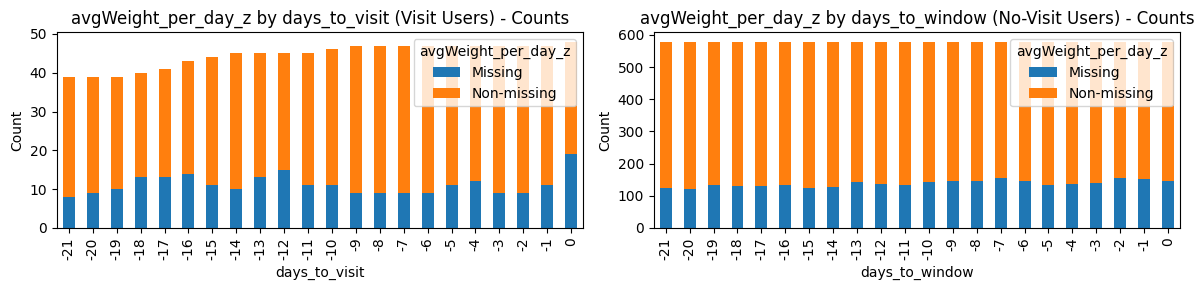

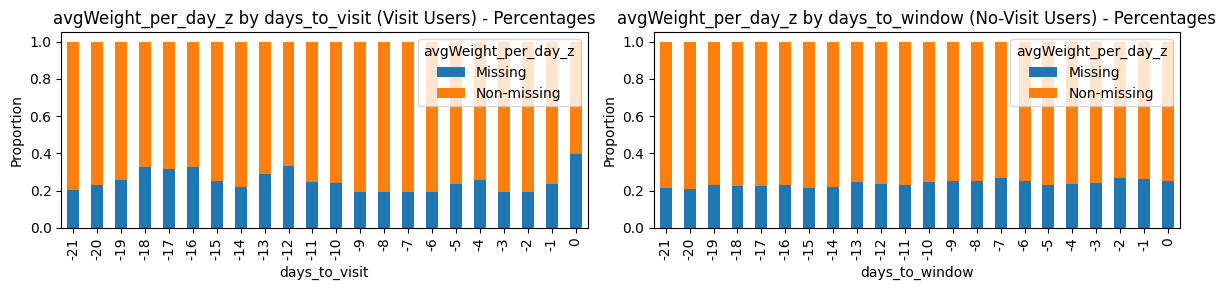

In [219]:
plot_feature_comparison(three_week_visit_weight, three_week_weight, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

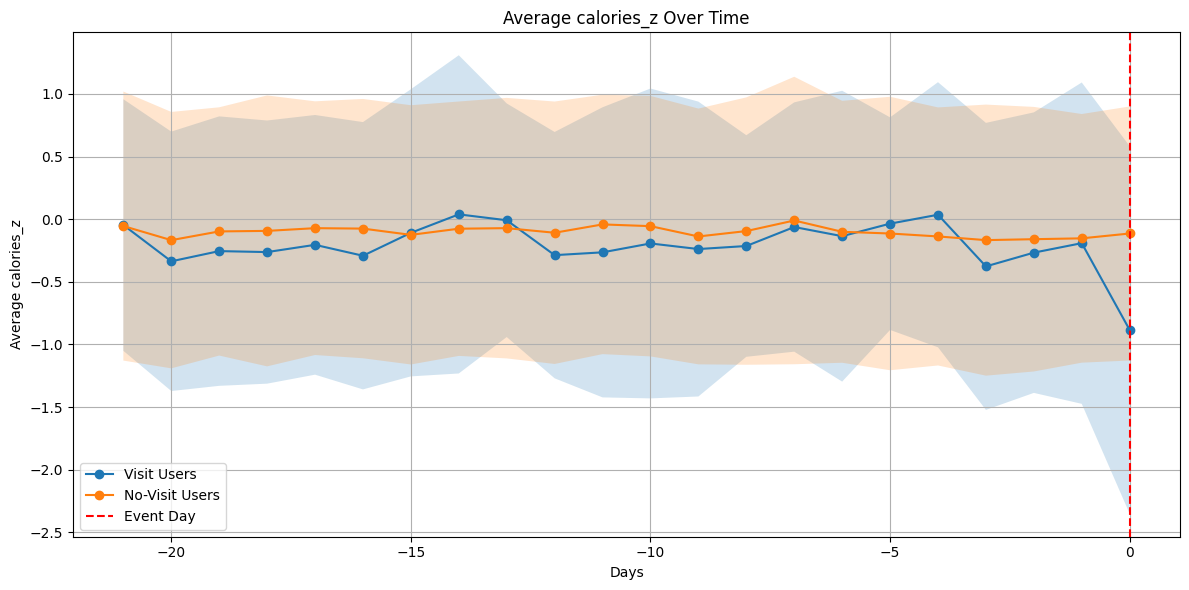

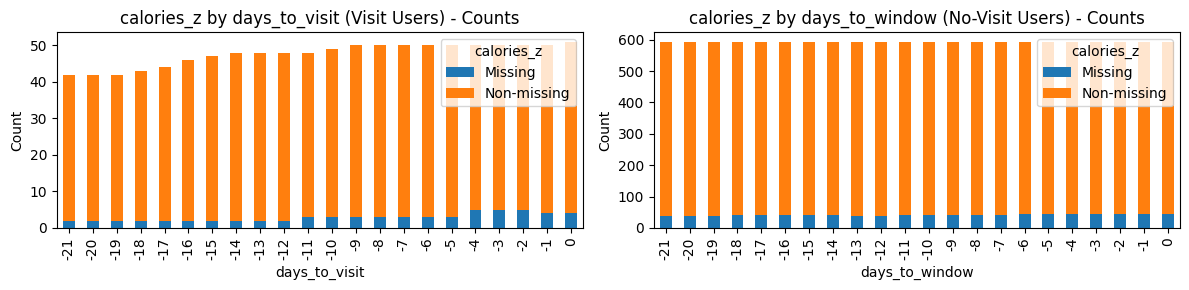

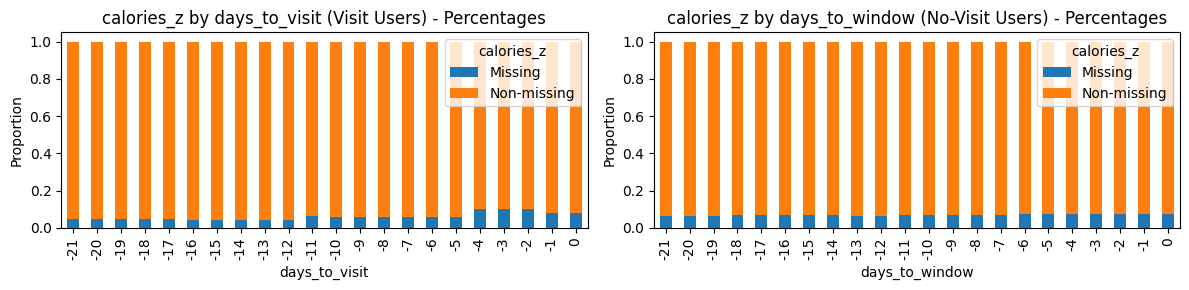

In [220]:
plot_feature_comparison(three_week_visit, three_week, 'calories_z', bin_continuous=True, n_bins=10)

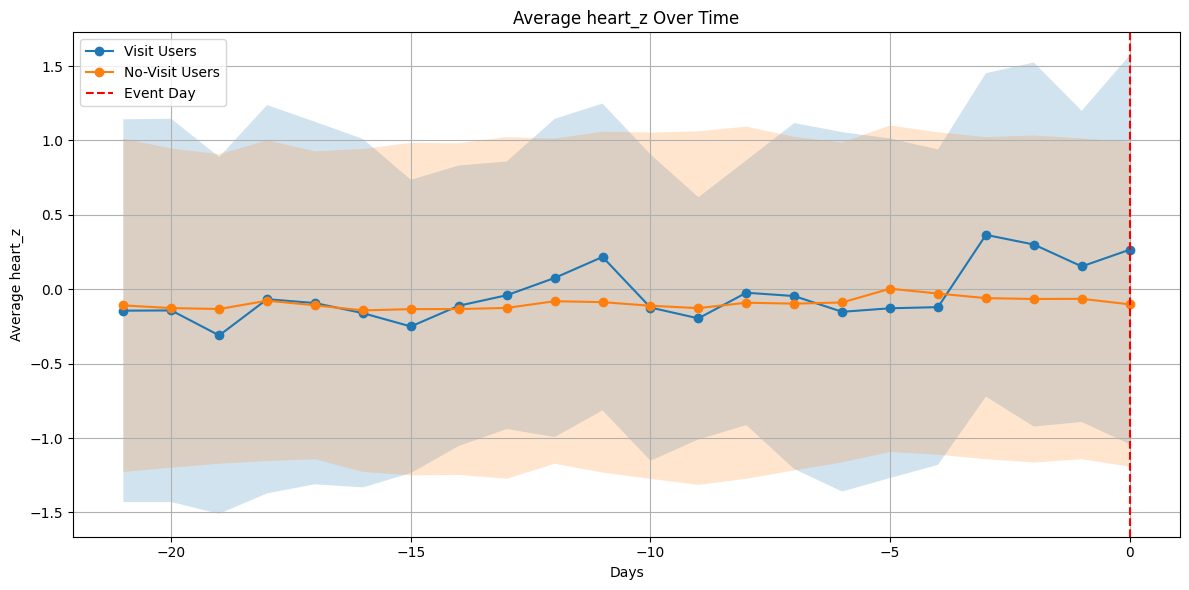

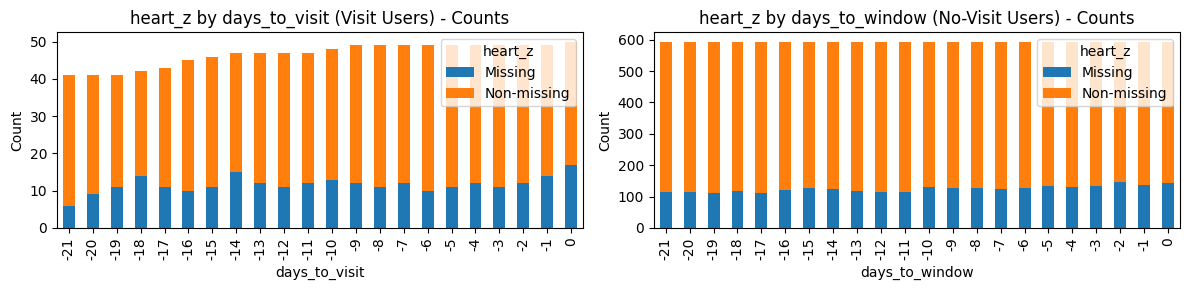

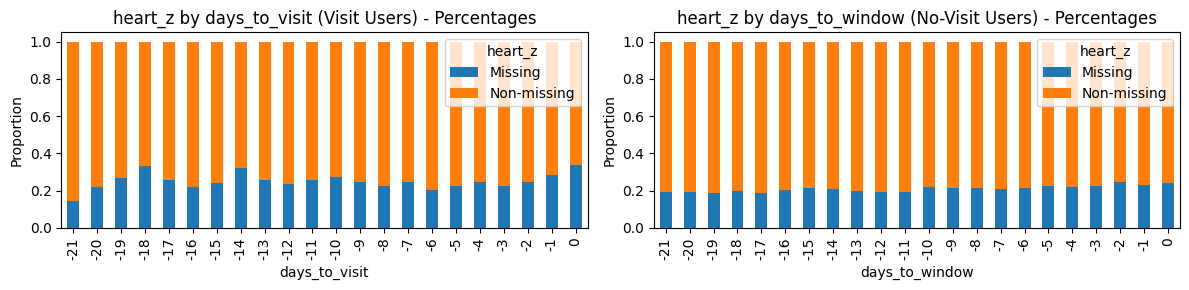

In [253]:
plot_feature_comparison(three_week_visit[three_week_visit['fitbit_user_id'] != 82], three_week, 'heart_z', bin_continuous=True, n_bins=10)

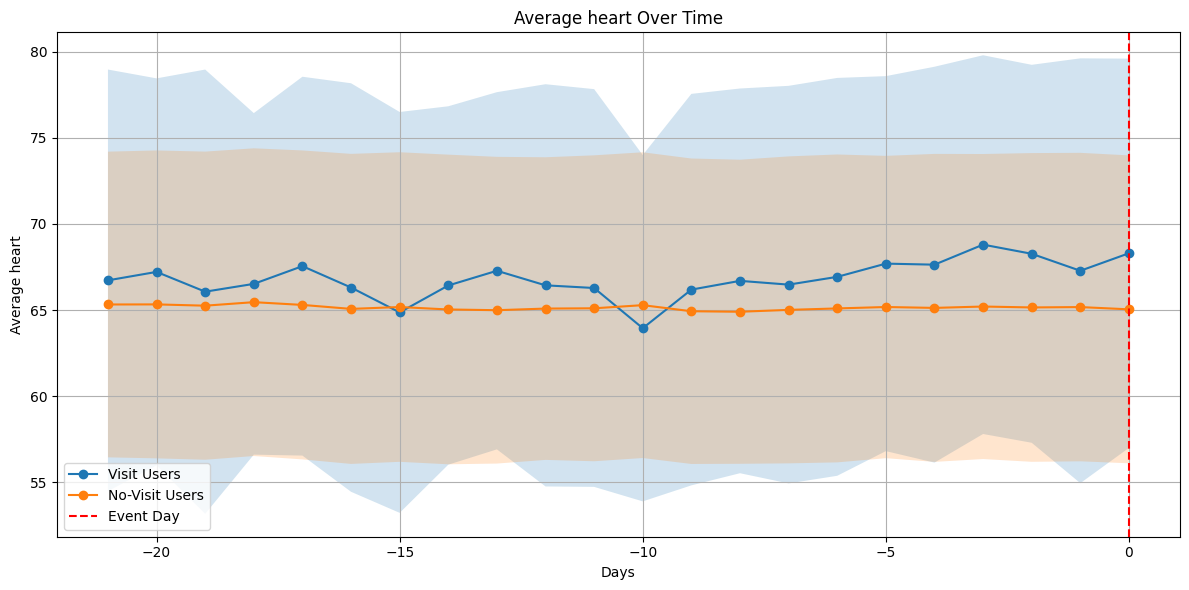

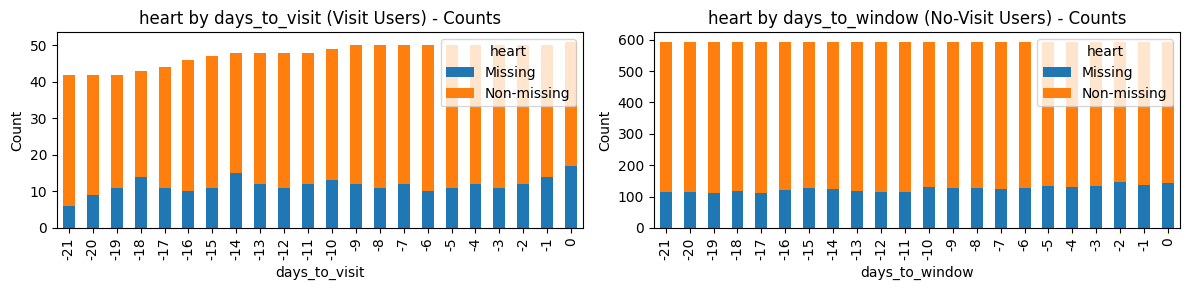

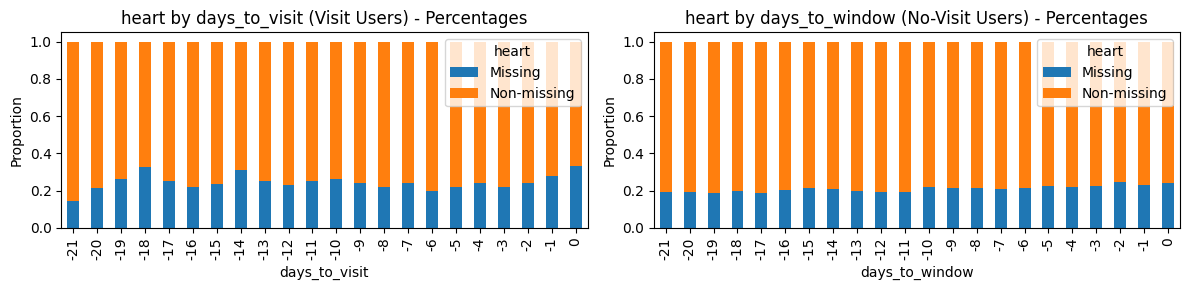

In [222]:
plot_feature_comparison(three_week_visit, three_week, 'heart', bin_continuous=True, n_bins=10)

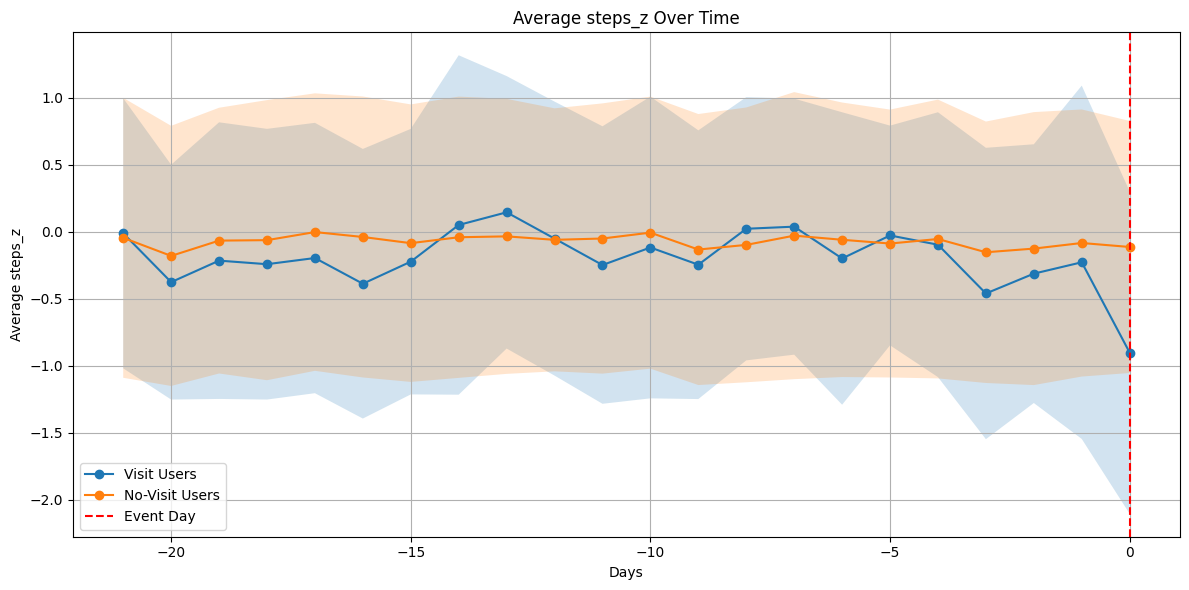

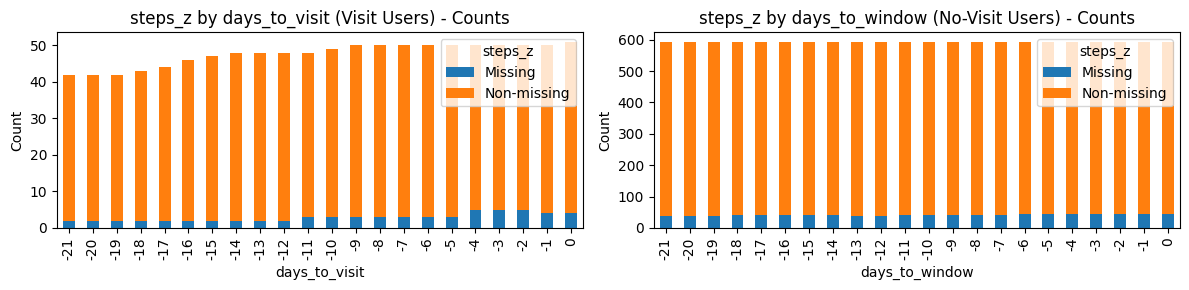

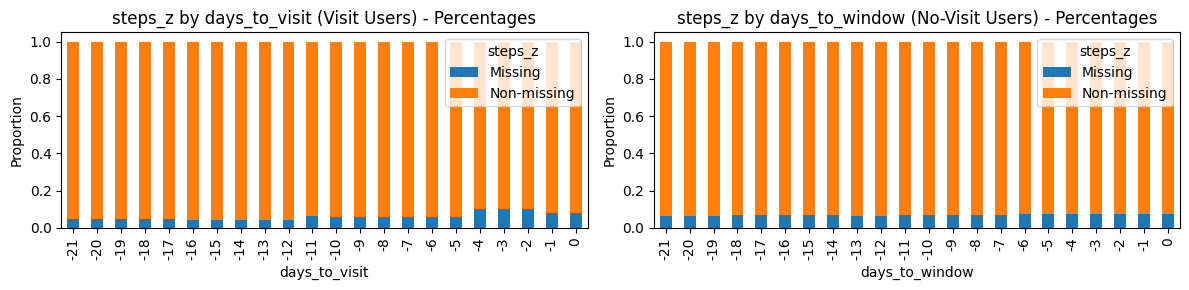

In [223]:
plot_feature_comparison(three_week_visit, three_week, 'steps_z', bin_continuous=True, n_bins=10)

In [224]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')

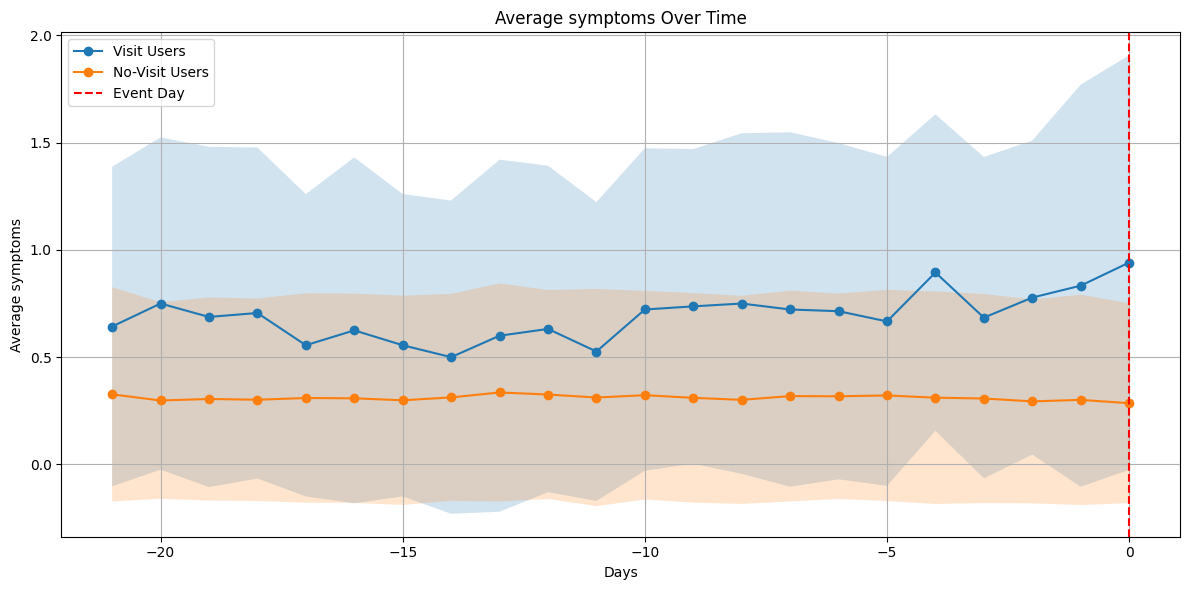

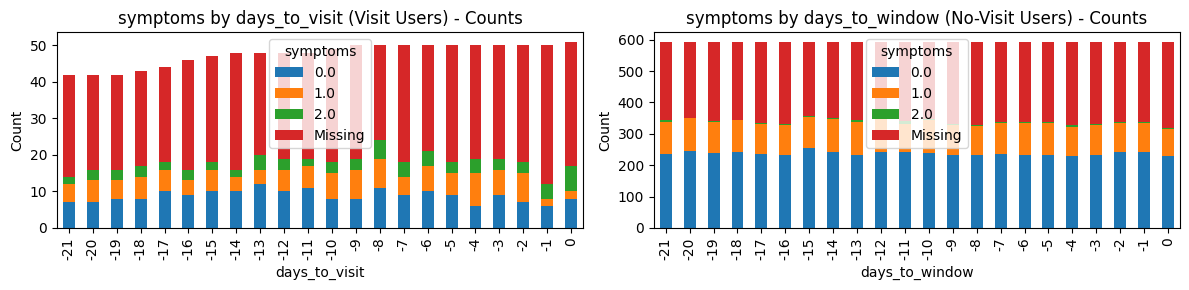

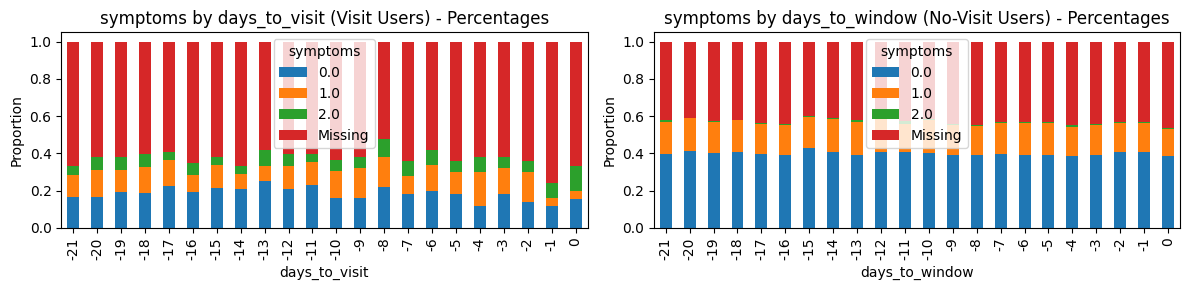

In [225]:
plot_feature_comparison(three_week_visit, three_week, 'symptoms', bin_continuous=False)

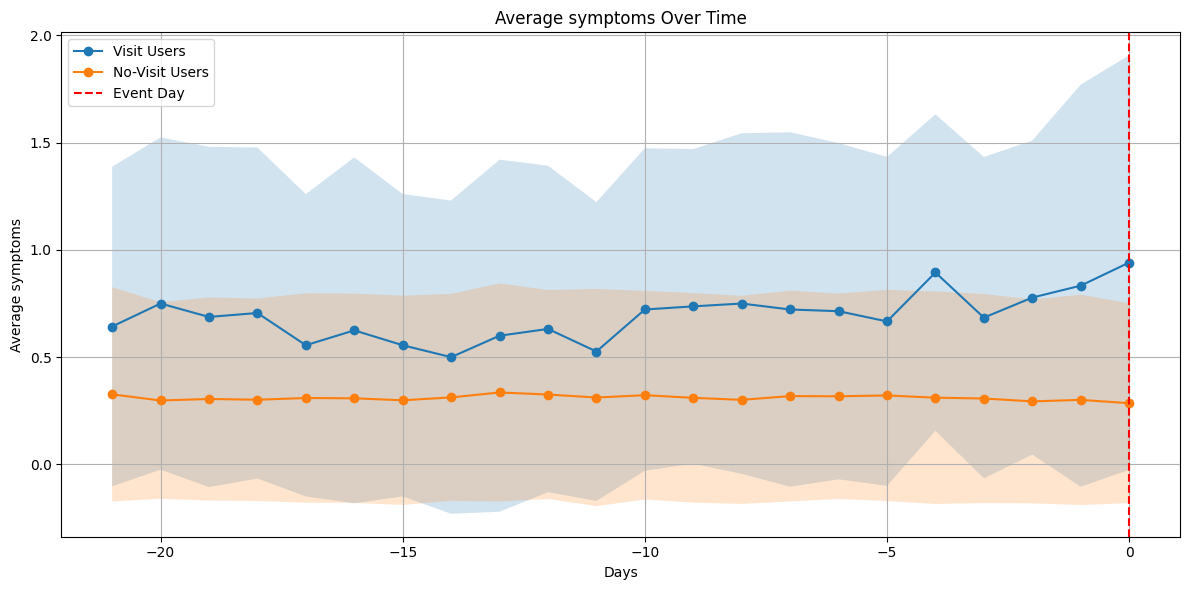

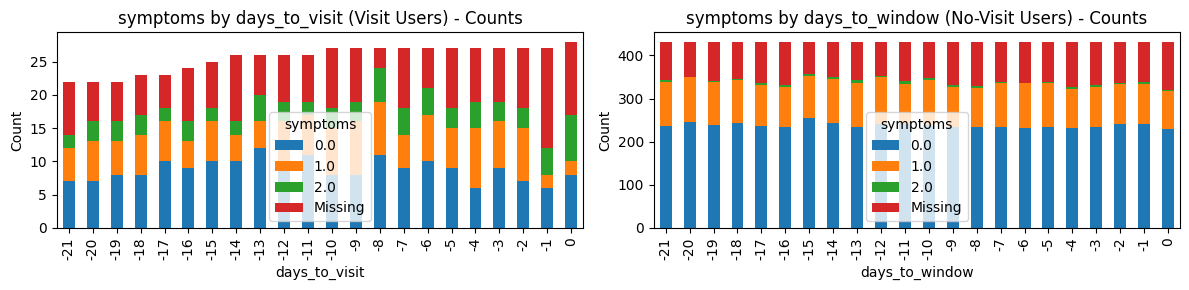

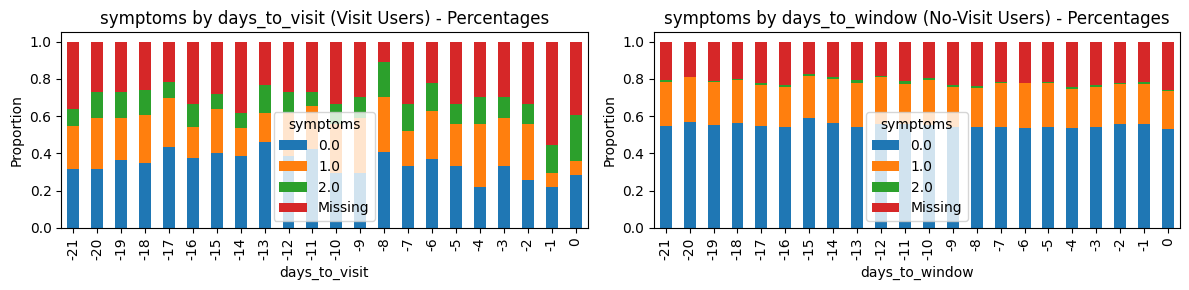

In [226]:
plot_feature_comparison(three_week_visit_symptoms, three_week_symptoms, 'symptoms', bin_continuous=False)

In [227]:
three_week_visit_hrv_deep = drop_nan_user(three_week_visit, 'hrv_deepRmssd_z')
three_week_hrv_deep = drop_nan_user(three_week, 'hrv_deepRmssd_z')

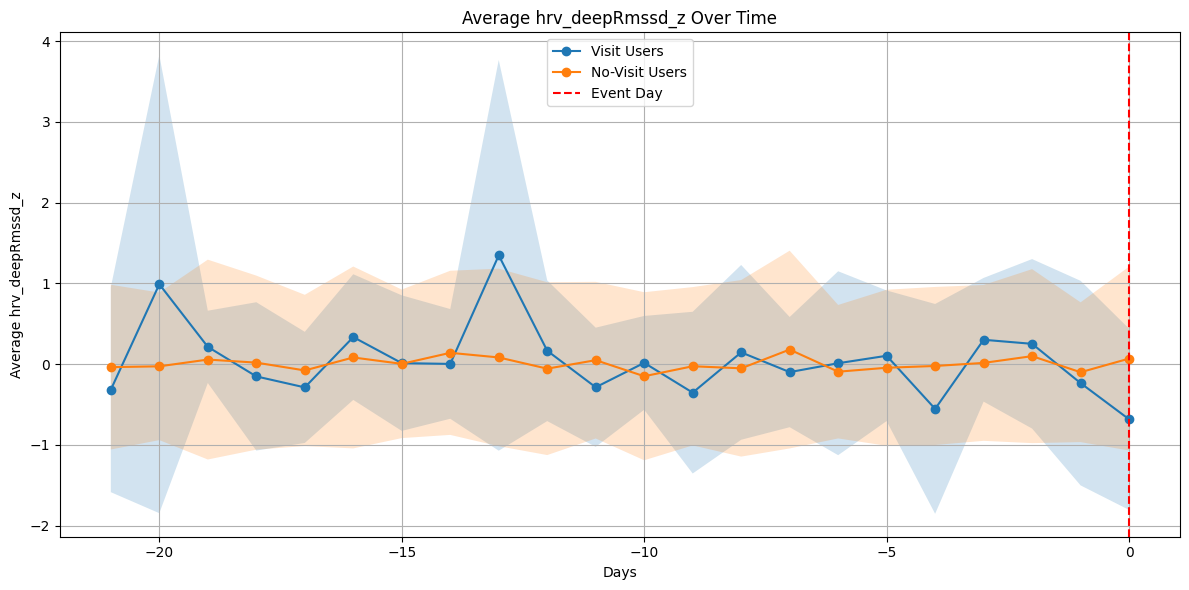

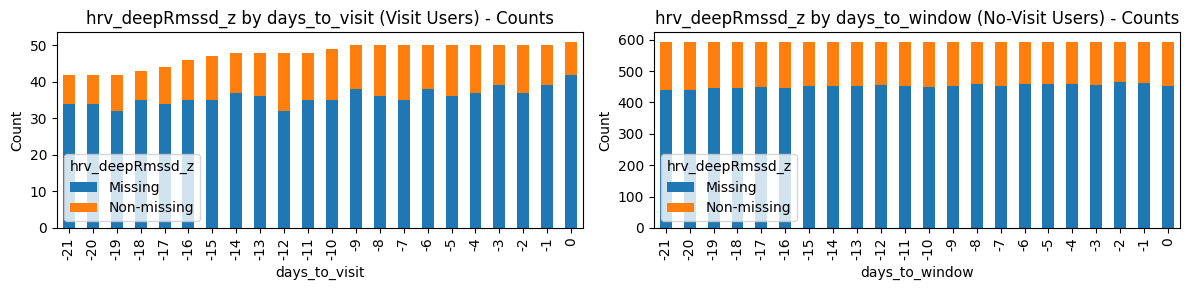

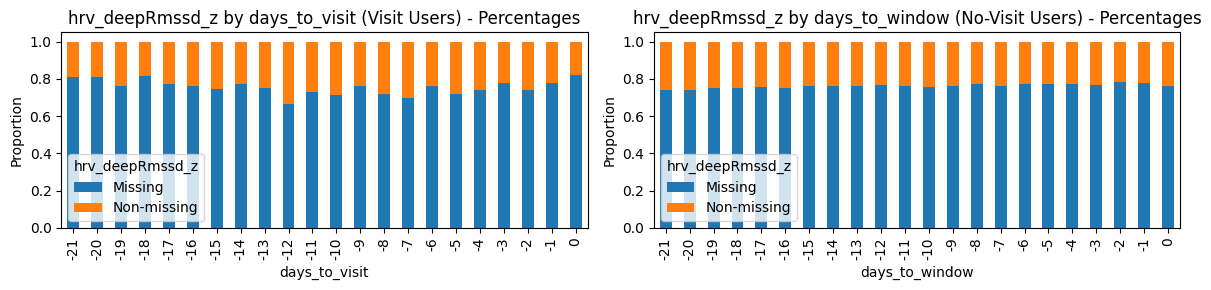

In [228]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_deepRmssd_z', bin_continuous=True)

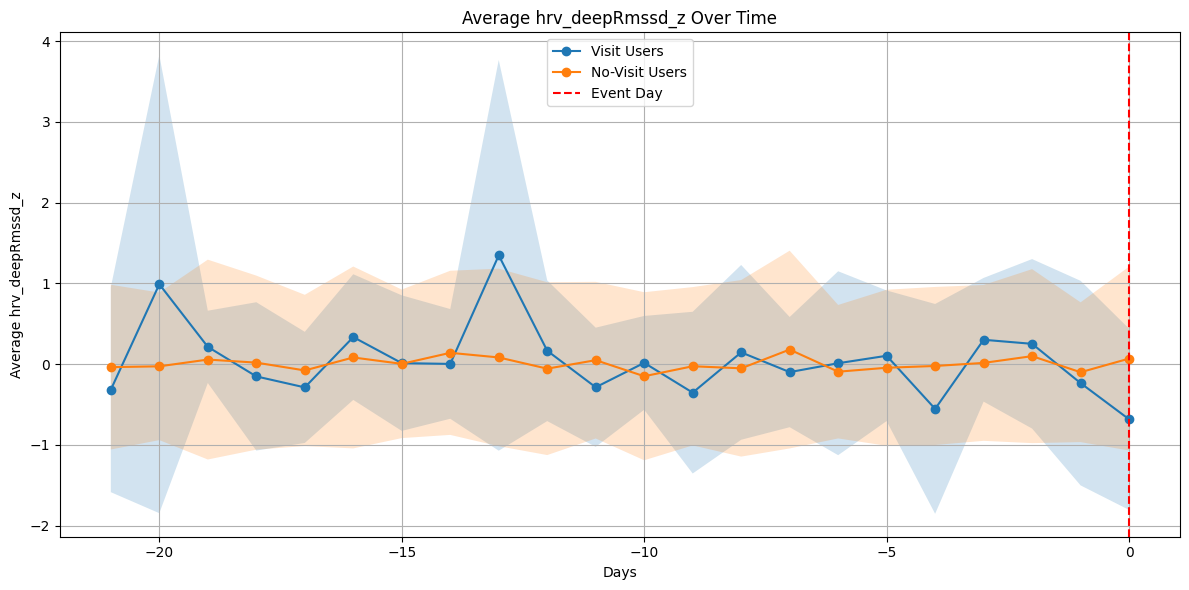

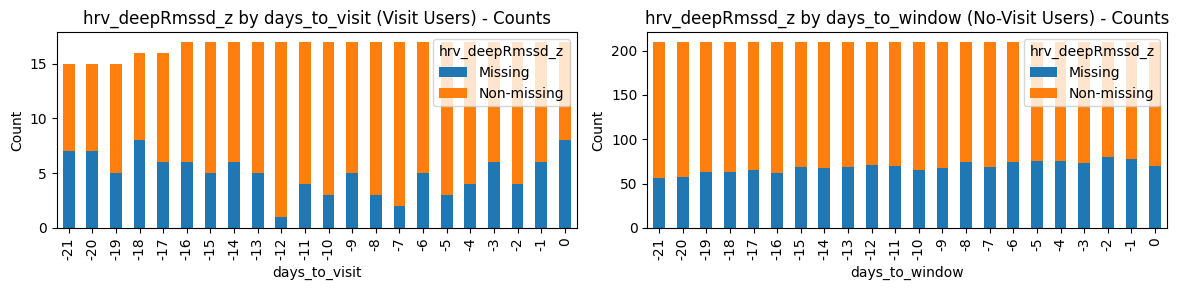

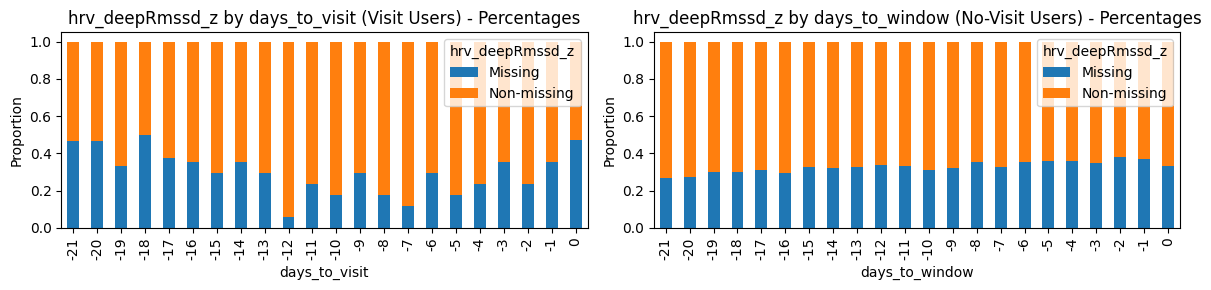

In [229]:
plot_feature_comparison(three_week_visit_hrv_deep, three_week_hrv_deep, 'hrv_deepRmssd_z', bin_continuous=True)

In [230]:
three_week_visit_hrv_daily = drop_nan_user(three_week_visit, 'hrv_dailyRmssd_z')
three_week_hrv_daily = drop_nan_user(three_week, 'hrv_dailyRmssd_z')

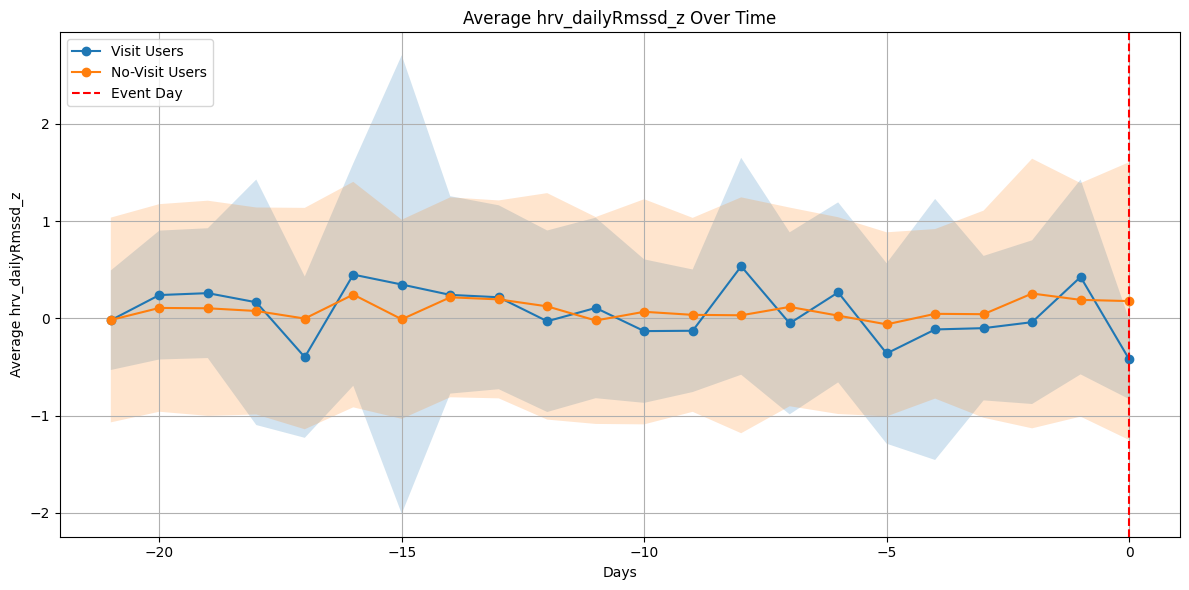

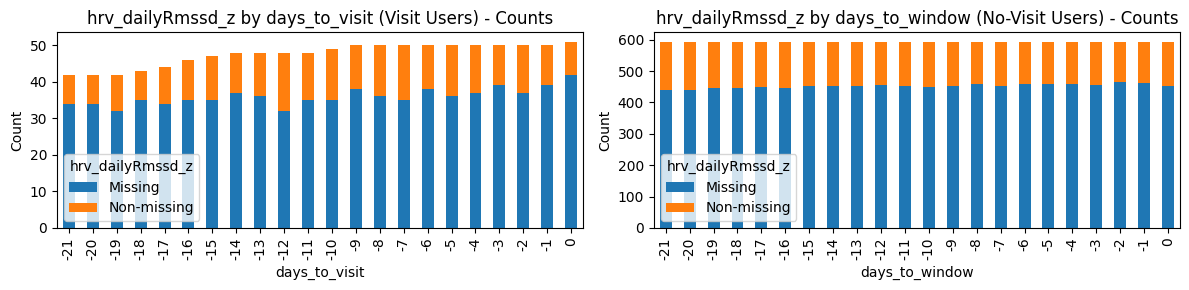

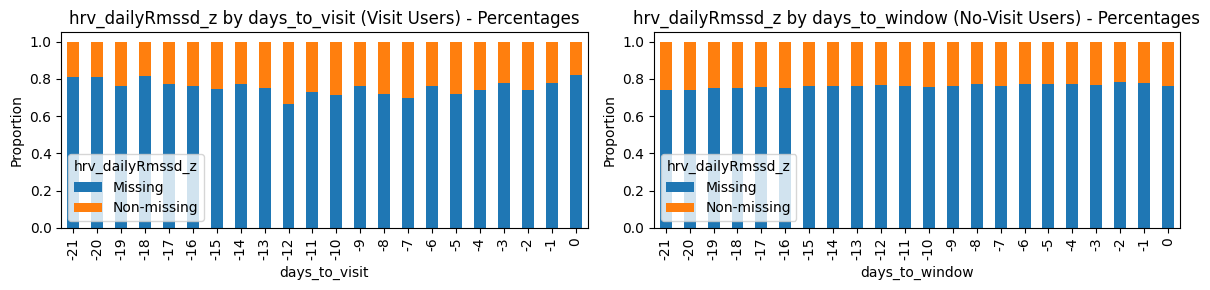

In [231]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_dailyRmssd_z', bin_continuous=True)

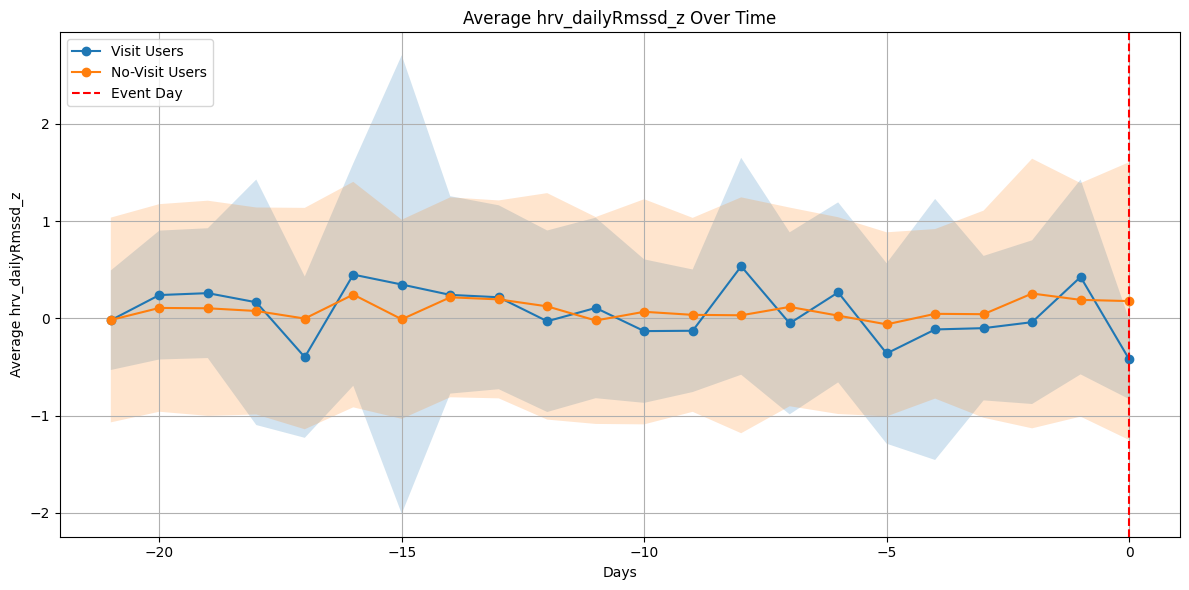

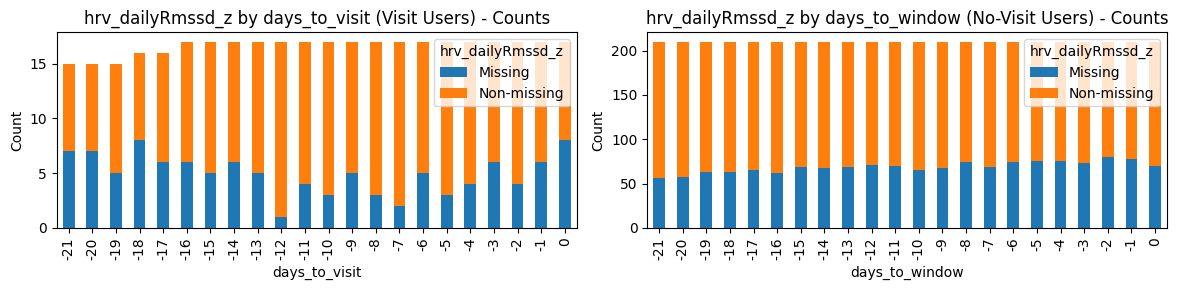

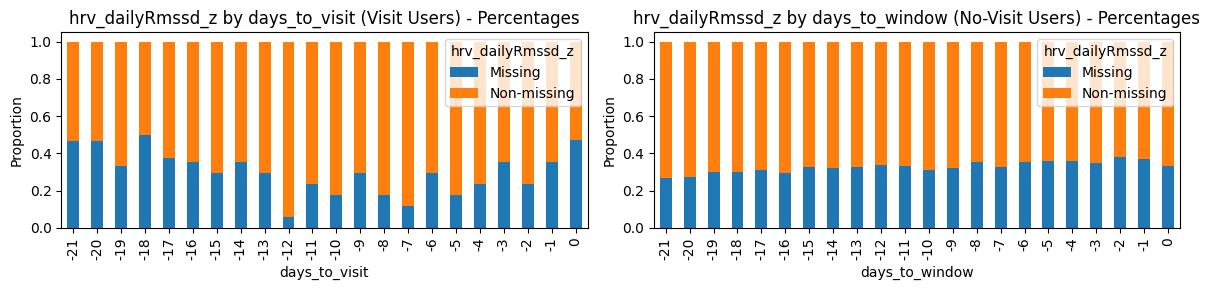

In [232]:
plot_feature_comparison(three_week_visit_hrv_daily, three_week_hrv_daily, 'hrv_dailyRmssd_z', bin_continuous=True)

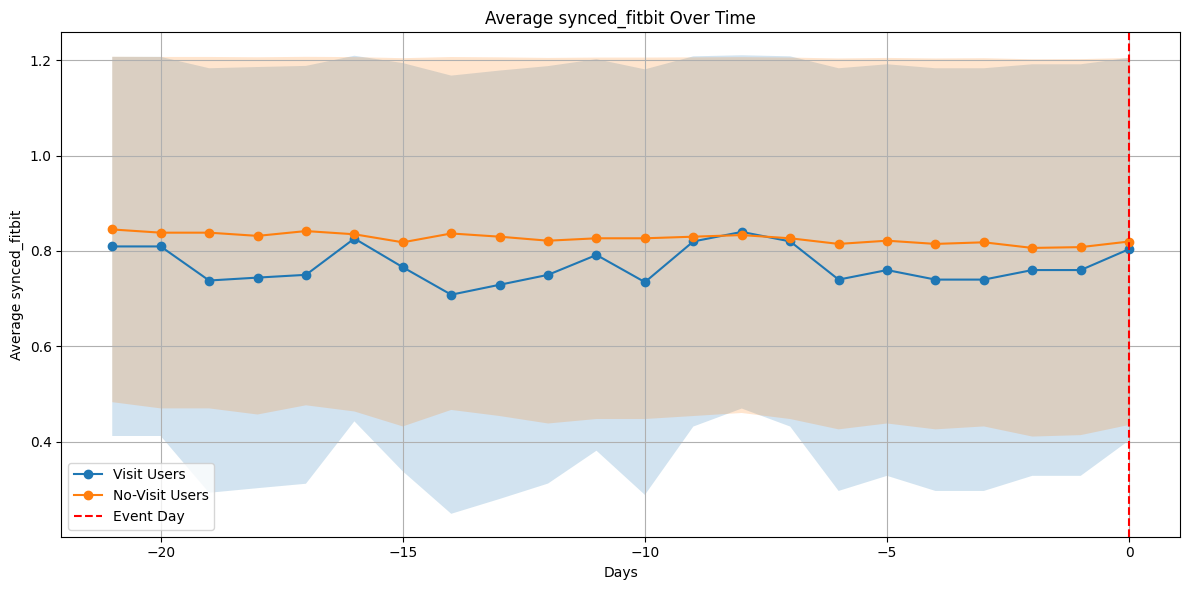

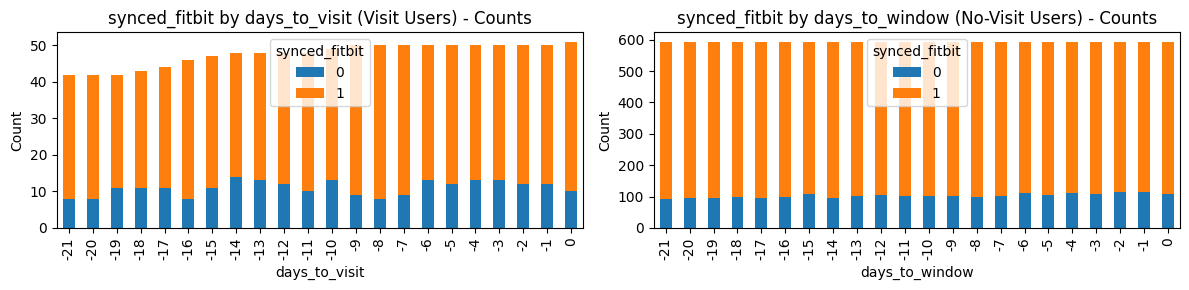

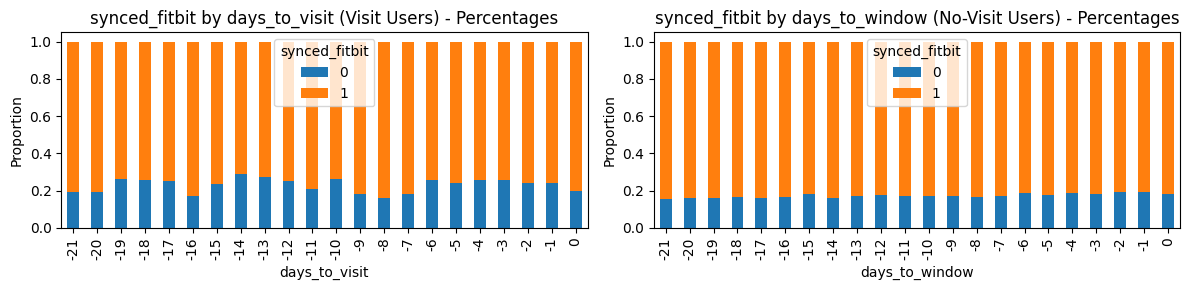

In [233]:
plot_feature_comparison(three_week_visit, three_week, 'synced_fitbit', bin_continuous=False)

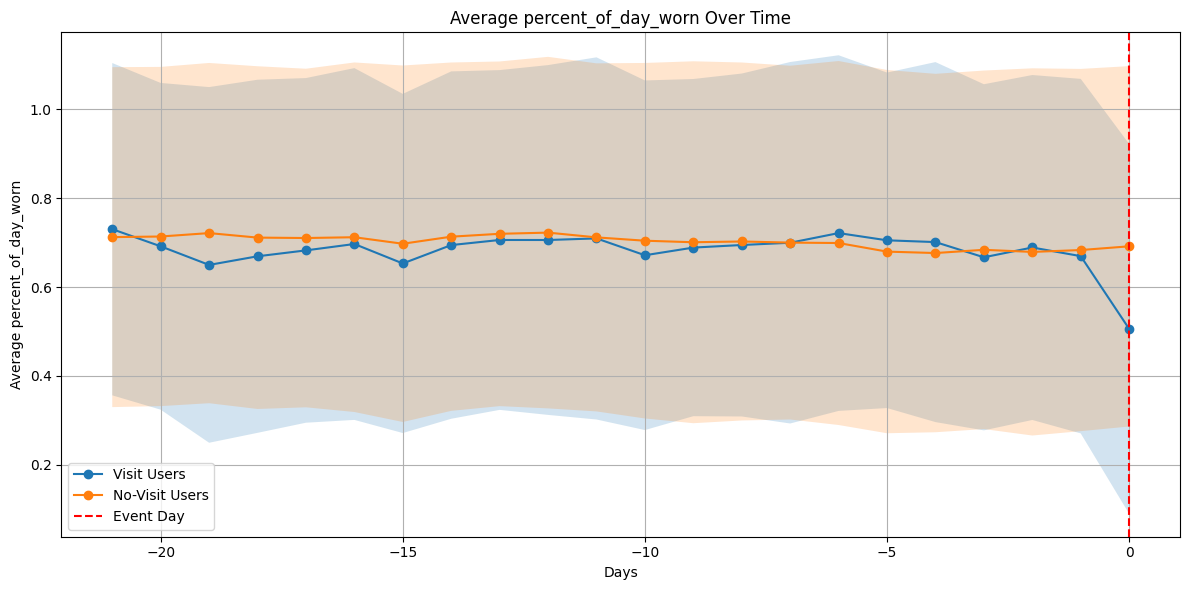

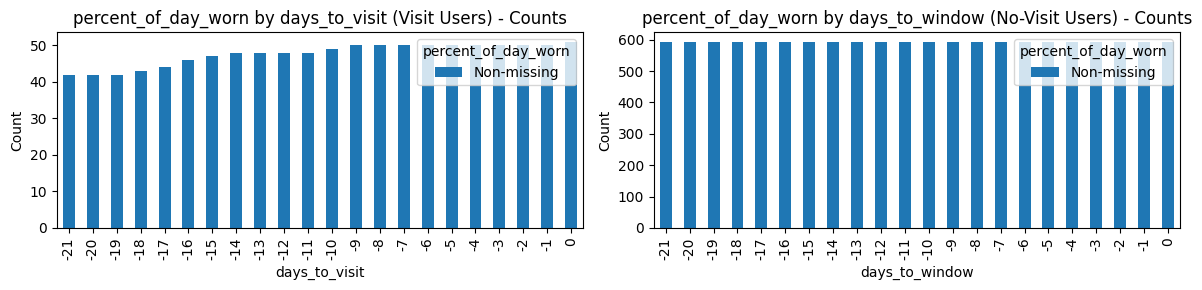

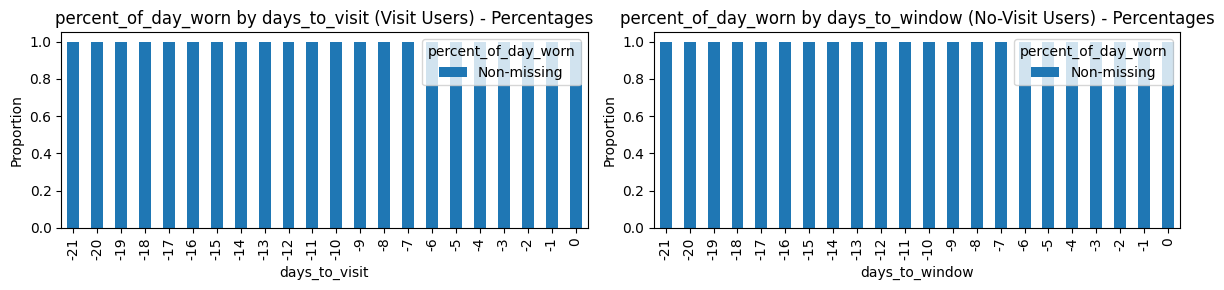

In [234]:
plot_feature_comparison(three_week_visit, three_week, 'percent_of_day_worn', bin_continuous=True)

In [235]:
three_week_visit_app = three_week_visit[three_week_visit['study_group'] != 'No App']
three_week_app = three_week[three_week['study_group'] != 'No App']

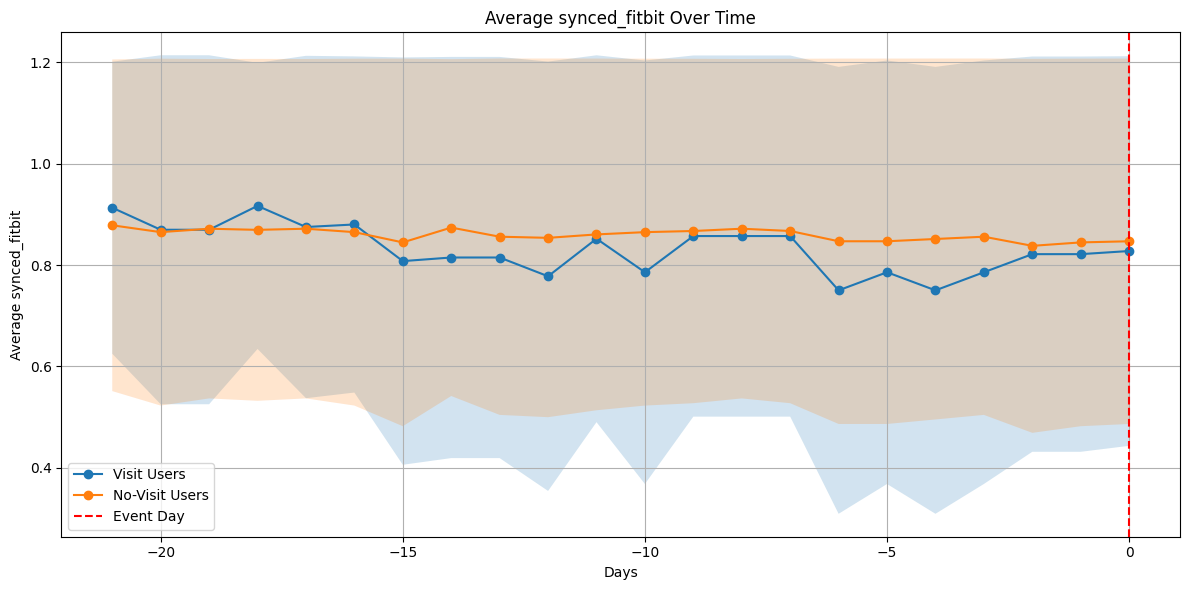

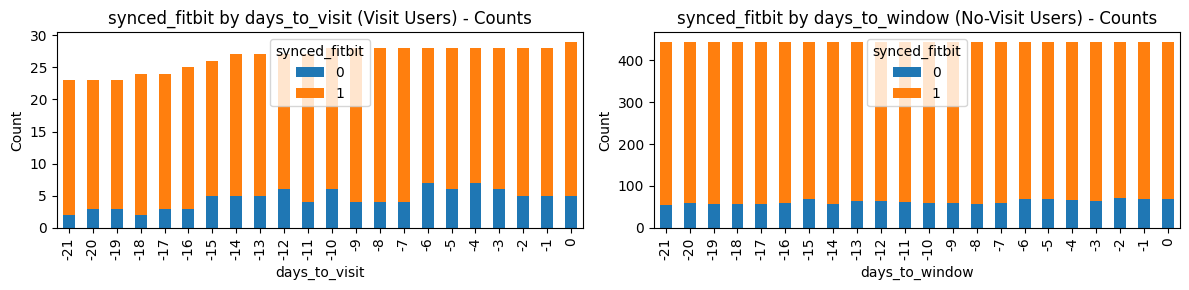

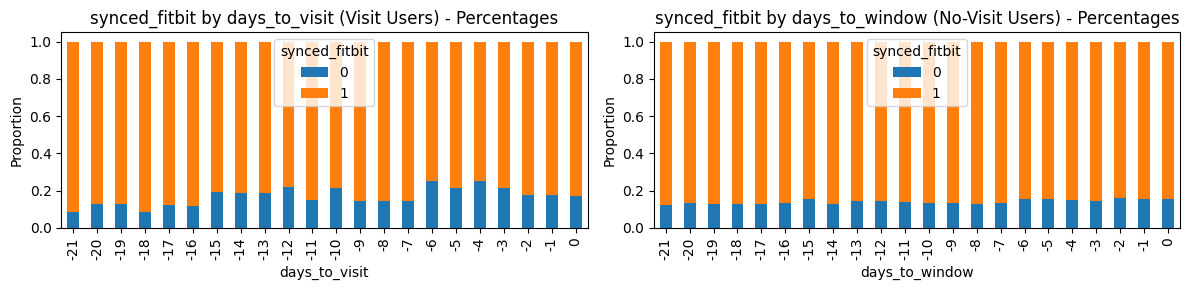

In [236]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'synced_fitbit', bin_continuous=False)

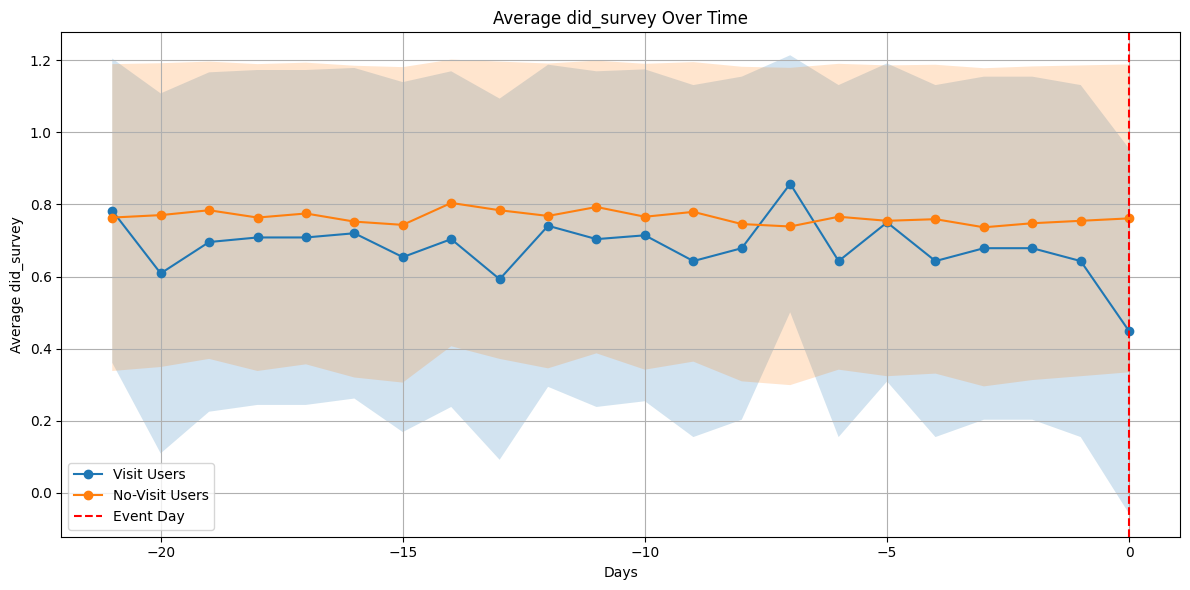

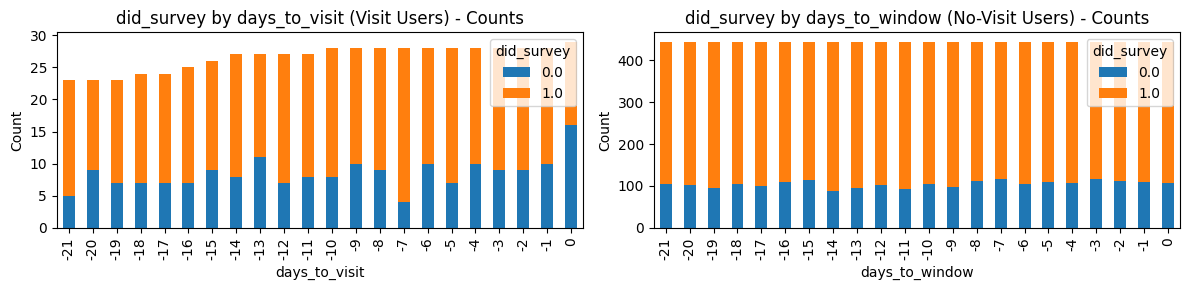

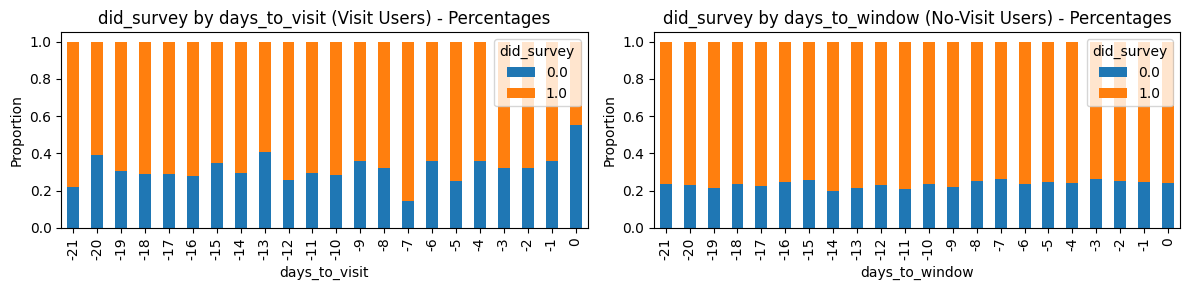

In [237]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'did_survey', bin_continuous=False)

### 2b) Two Week

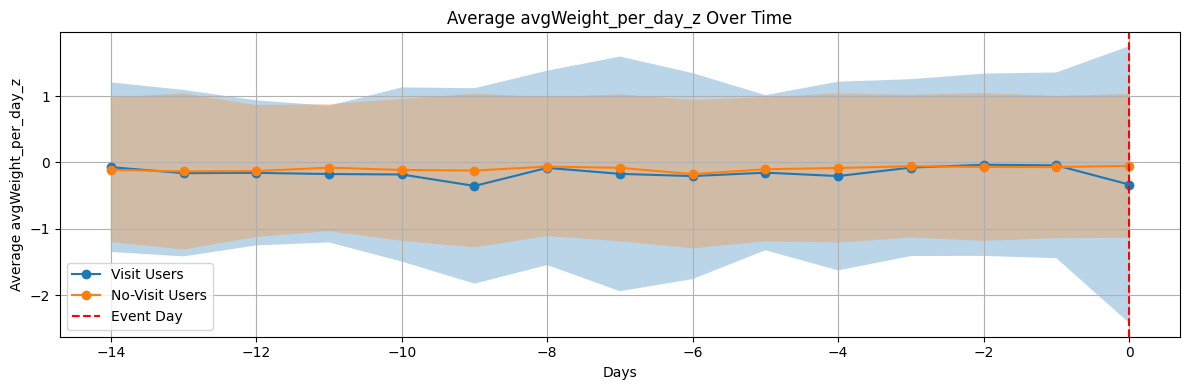

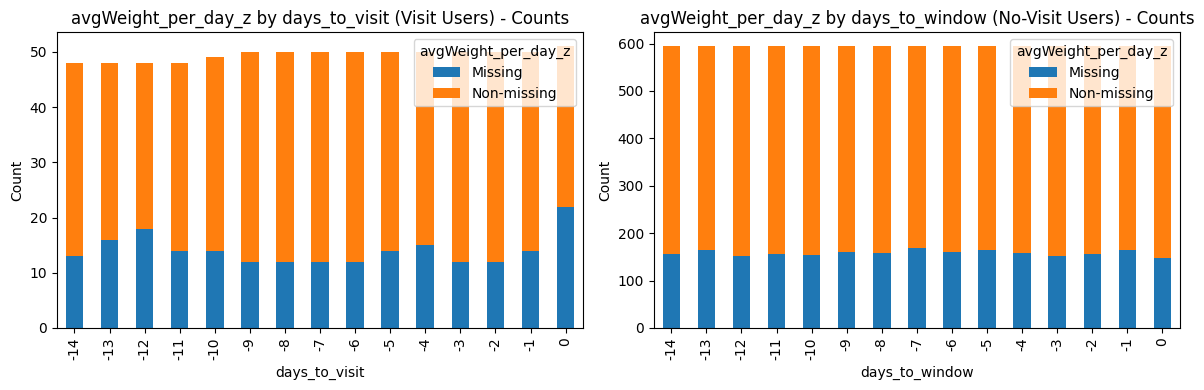

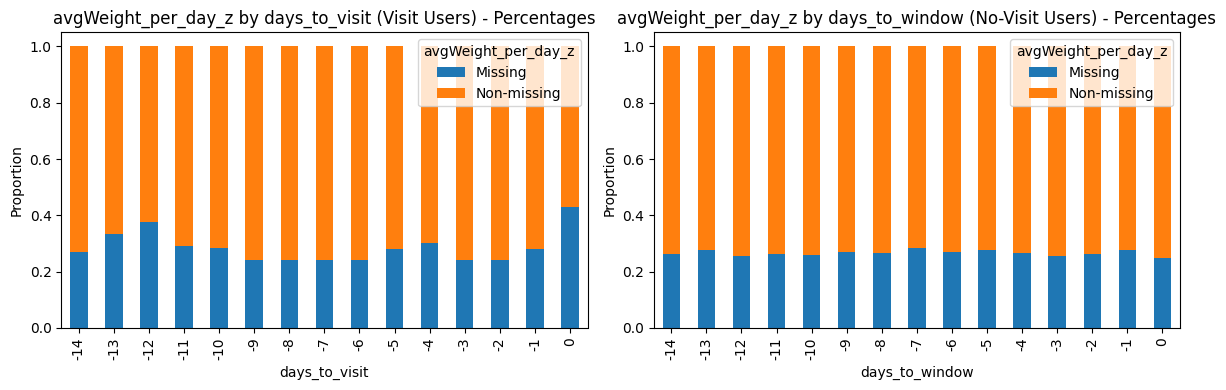

In [165]:
plot_feature_comparison(two_week_visit, two_week, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

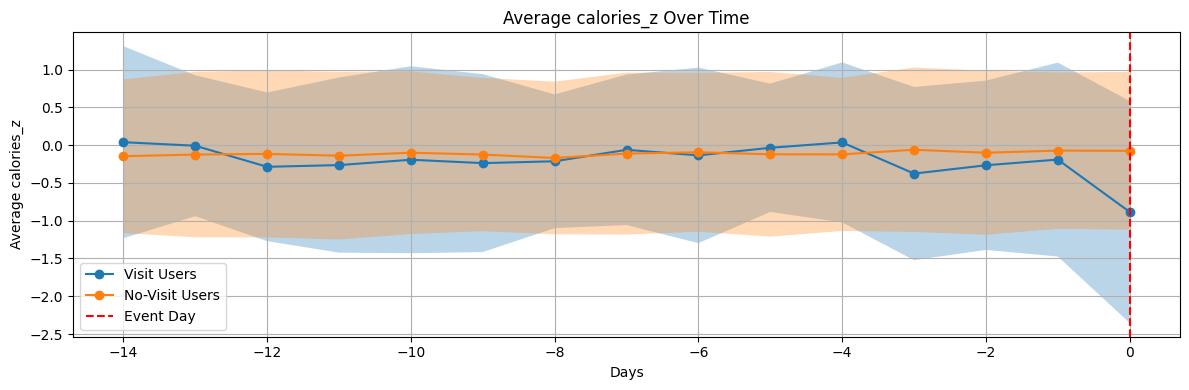

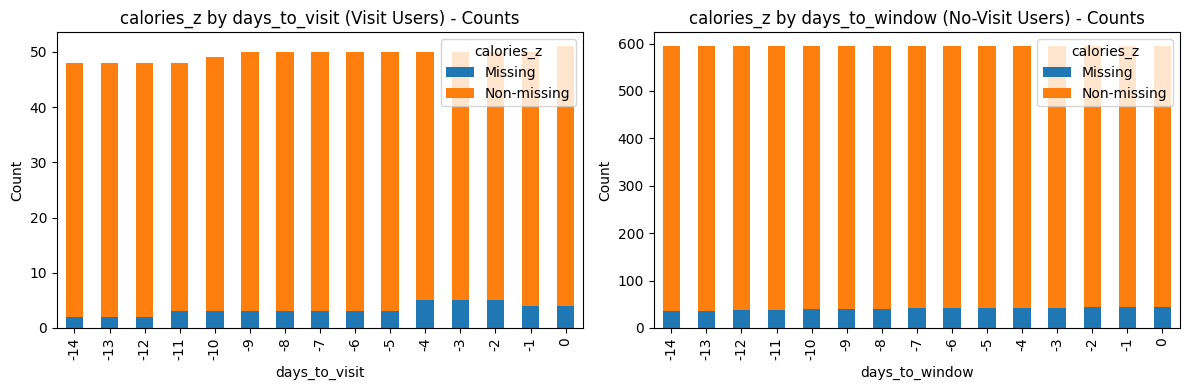

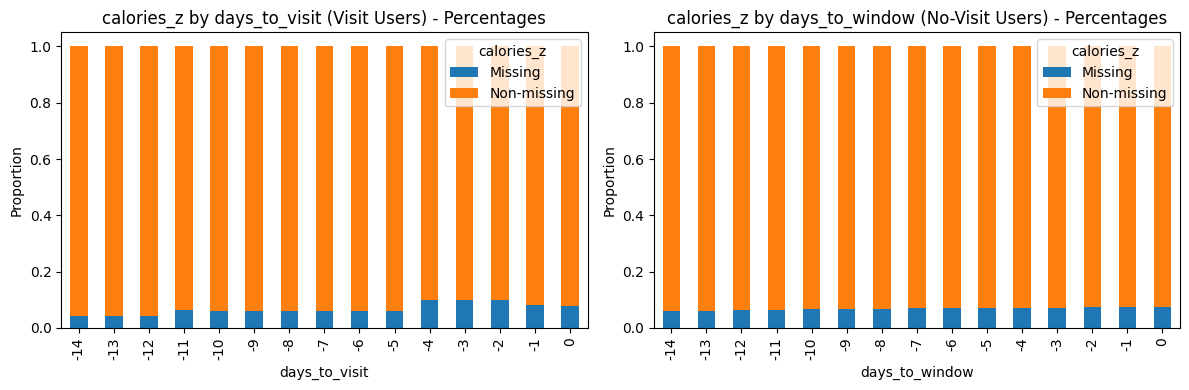

In [166]:
plot_feature_comparison(two_week_visit, two_week, 'calories_z', bin_continuous=True, n_bins=10)

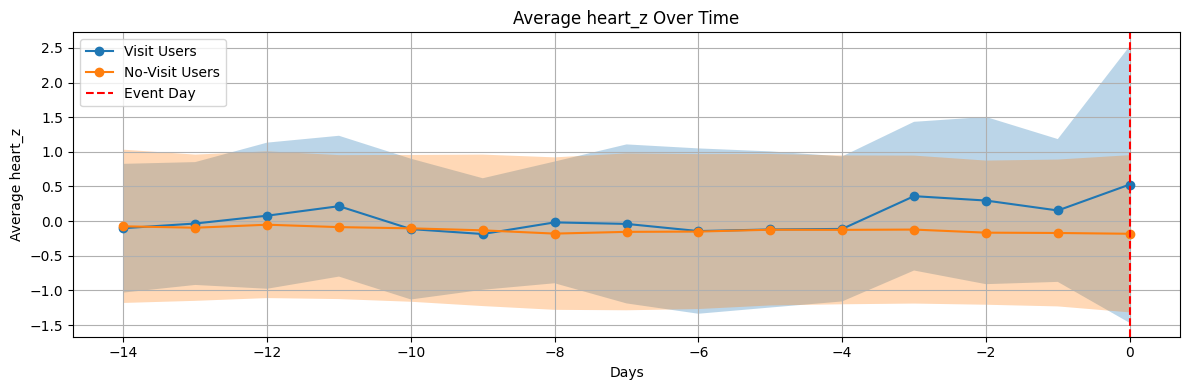

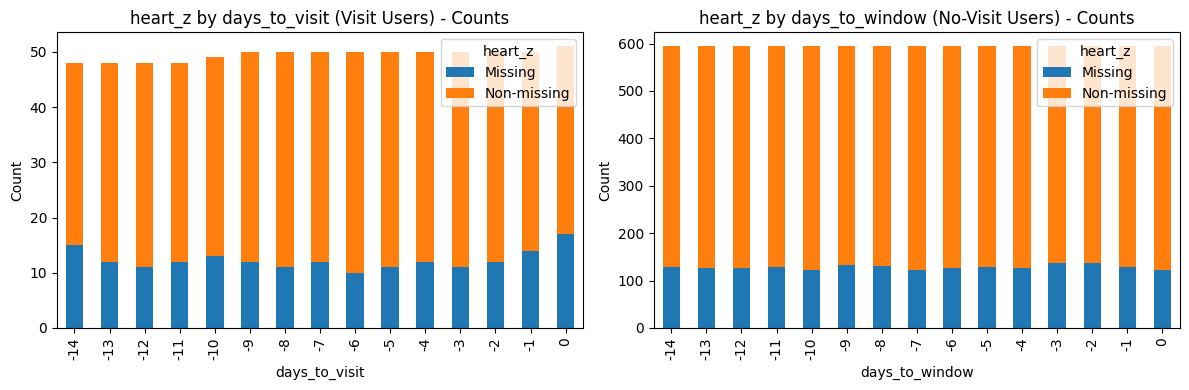

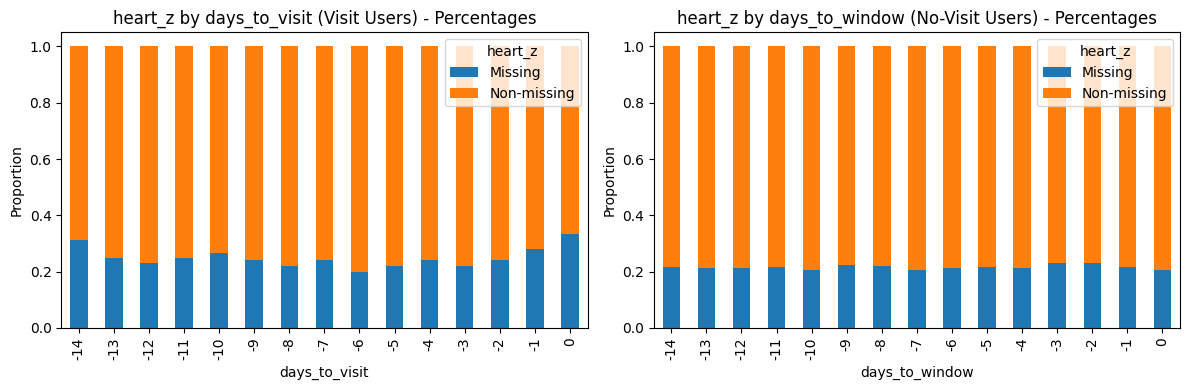

In [167]:
plot_feature_comparison(two_week_visit, two_week, 'heart_z', bin_continuous=True, n_bins=10)

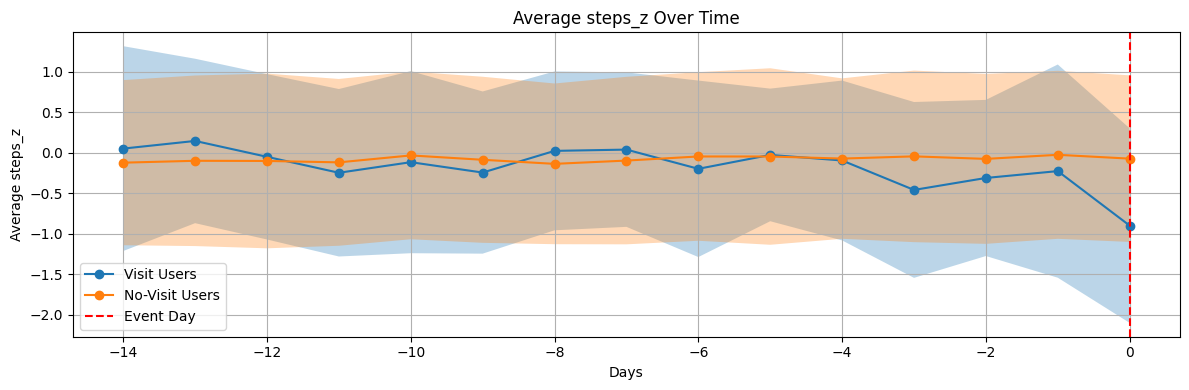

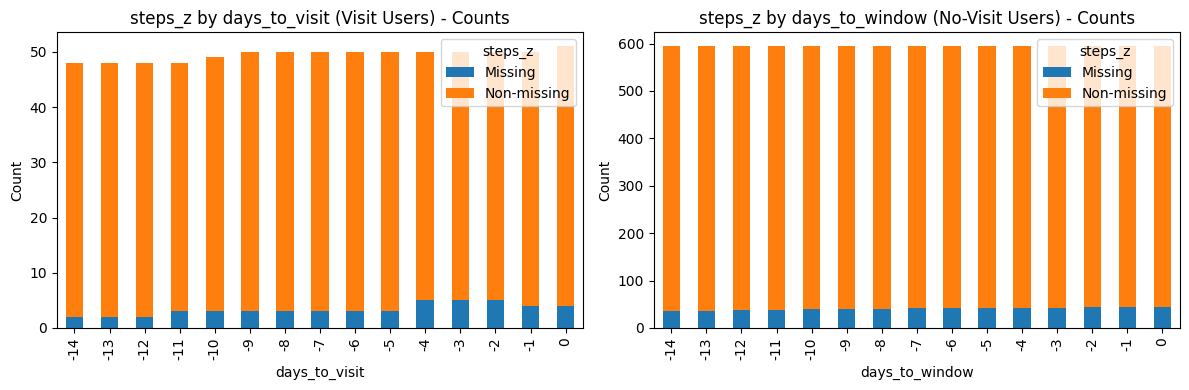

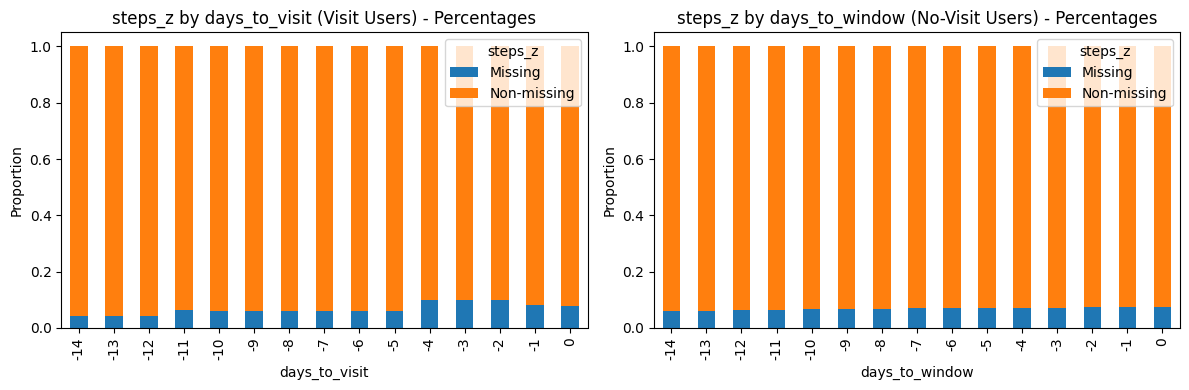

In [168]:
plot_feature_comparison(two_week_visit, two_week, 'steps_z', bin_continuous=True, n_bins=10)

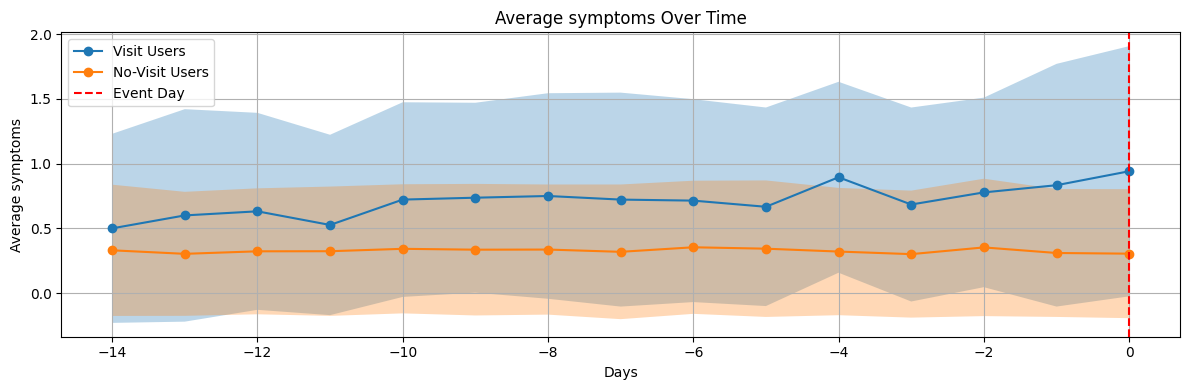

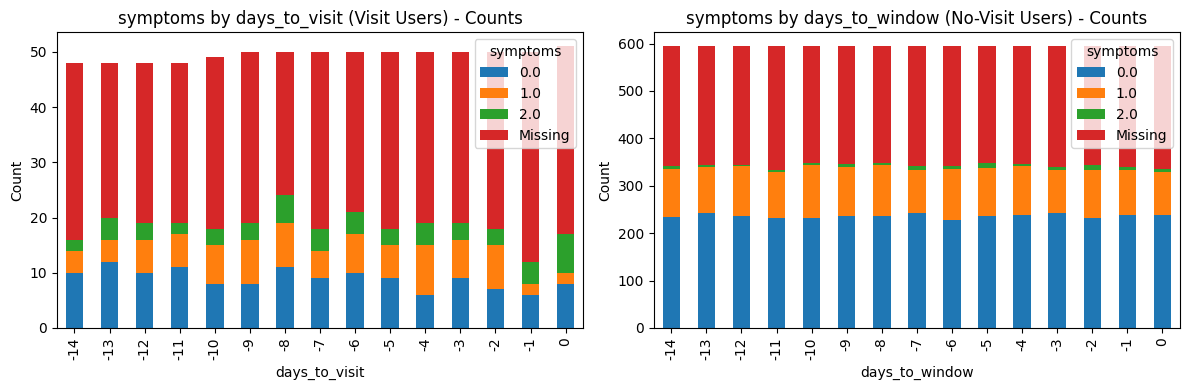

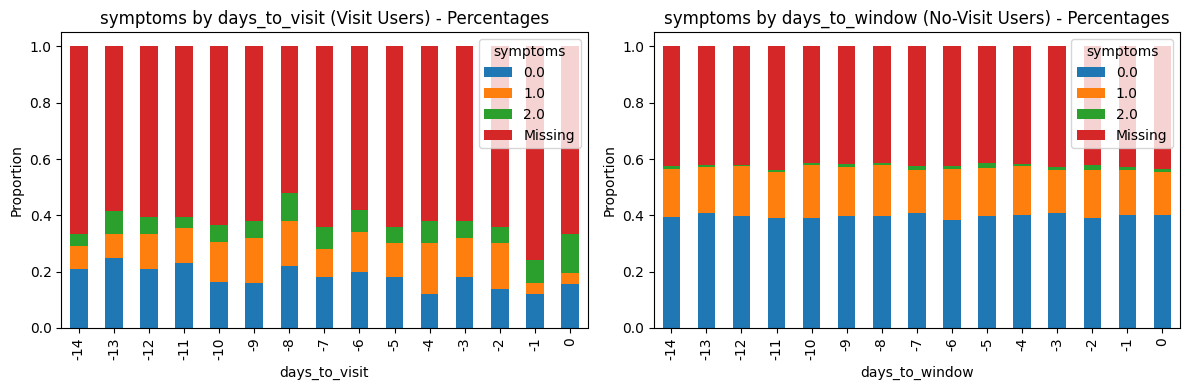

In [169]:
plot_feature_comparison(two_week_visit, two_week, 'symptoms', bin_continuous=False)

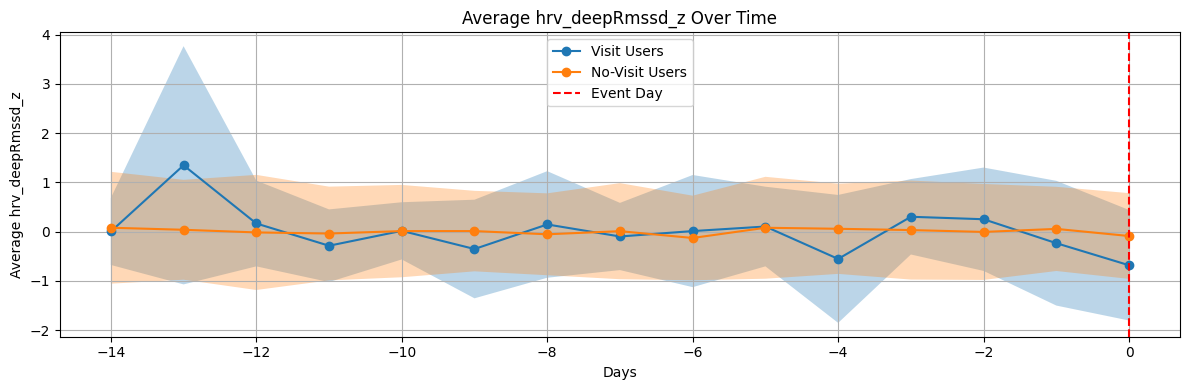

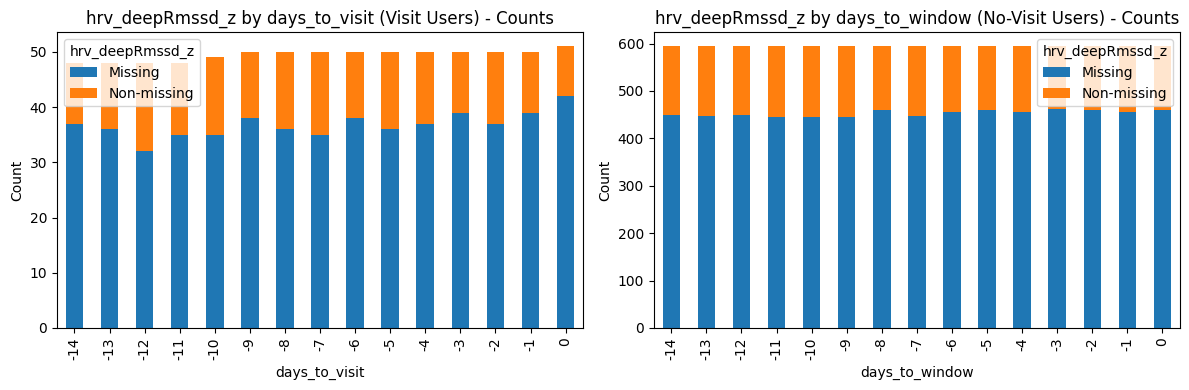

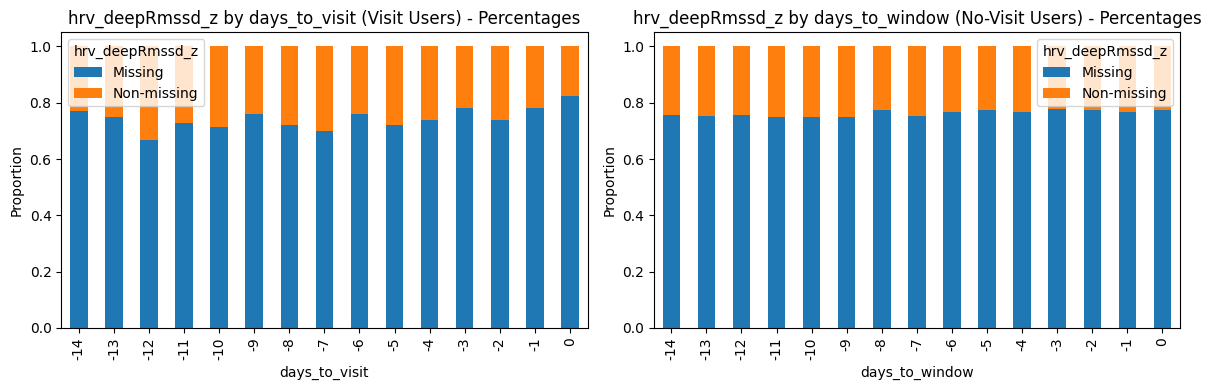

In [170]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_deepRmssd_z', bin_continuous=True)

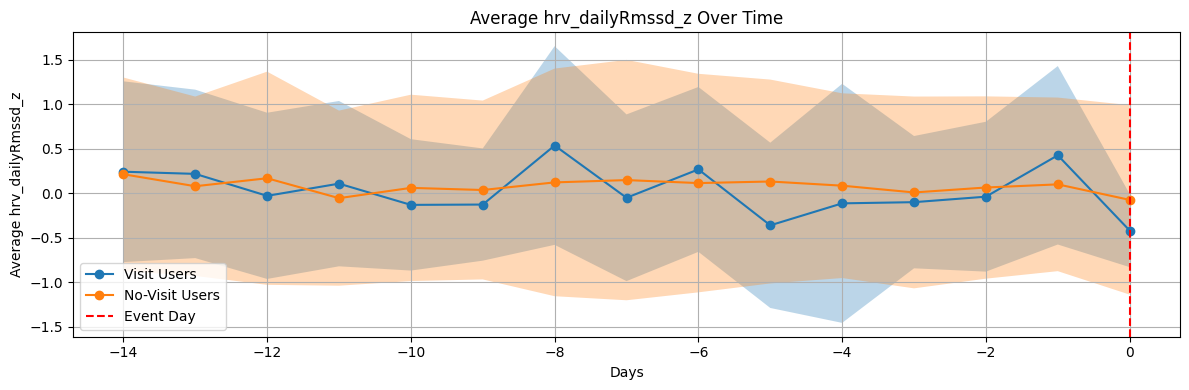

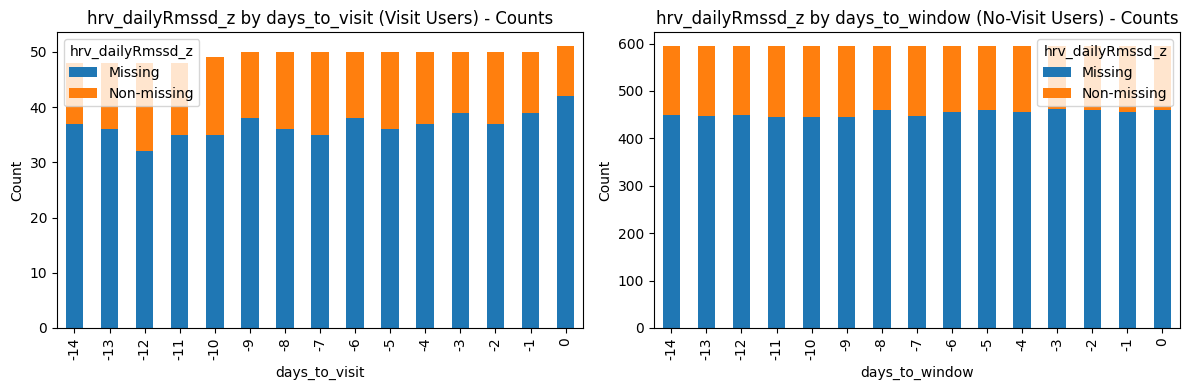

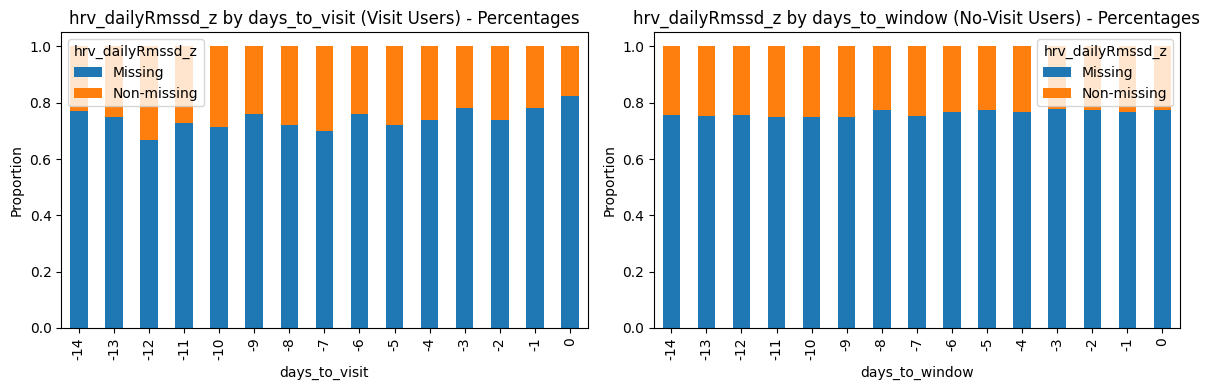

In [171]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_dailyRmssd_z', bin_continuous=True)

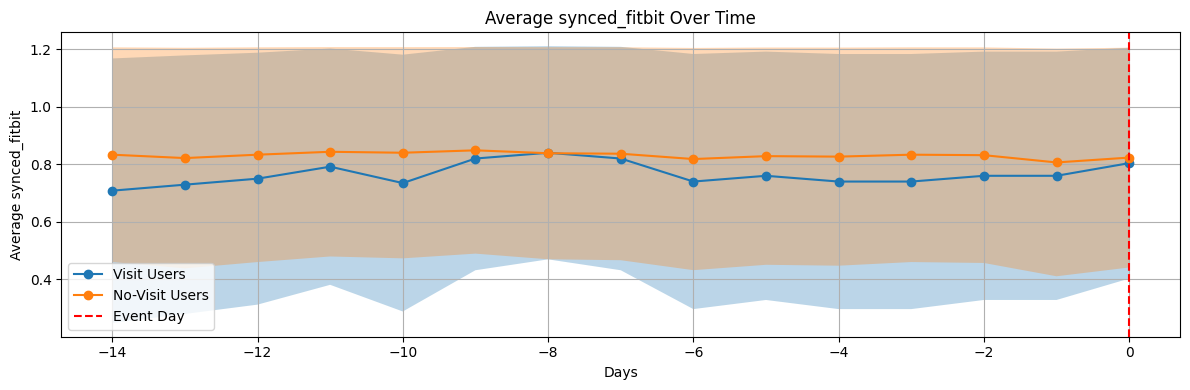

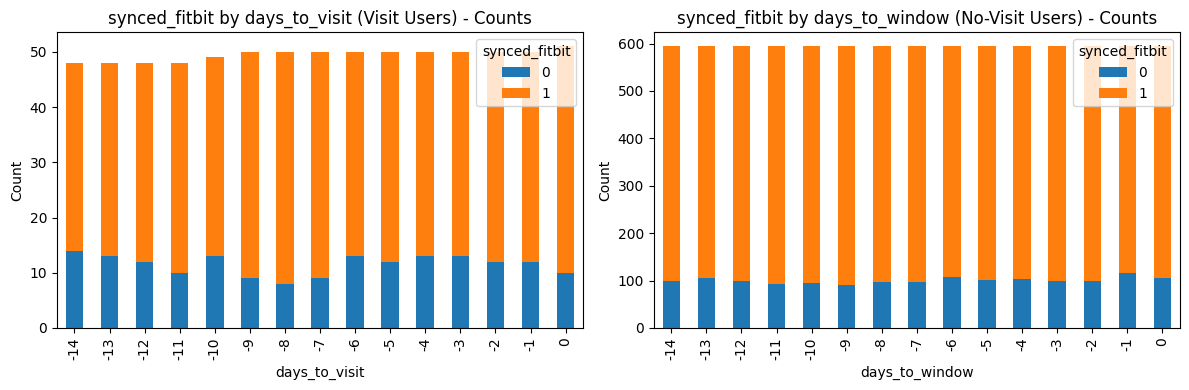

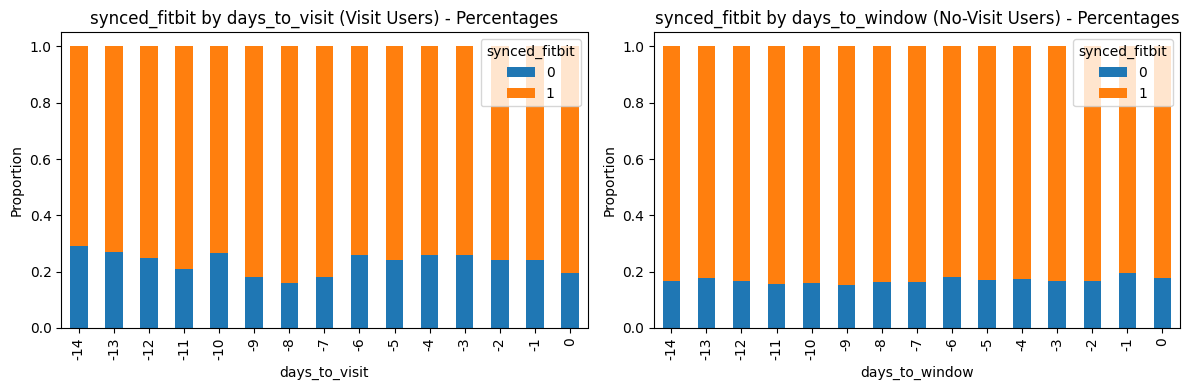

In [172]:
plot_feature_comparison(two_week_visit, two_week, 'synced_fitbit', bin_continuous=False)

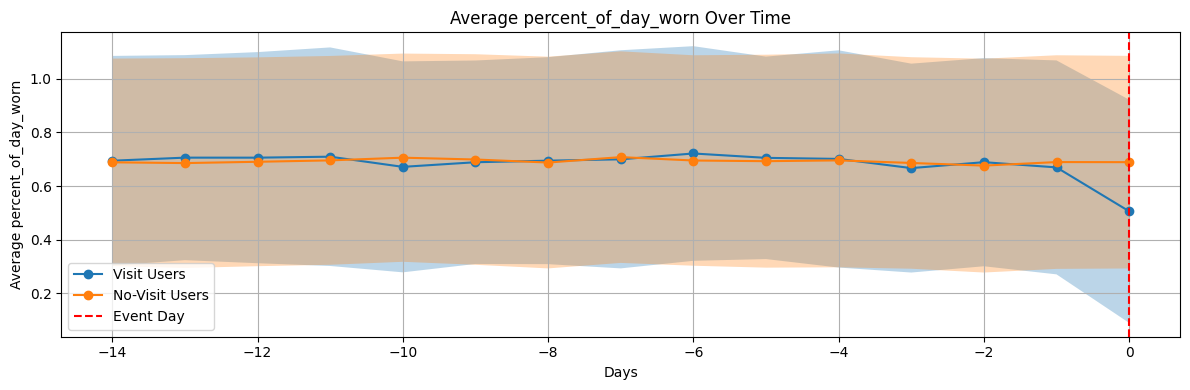

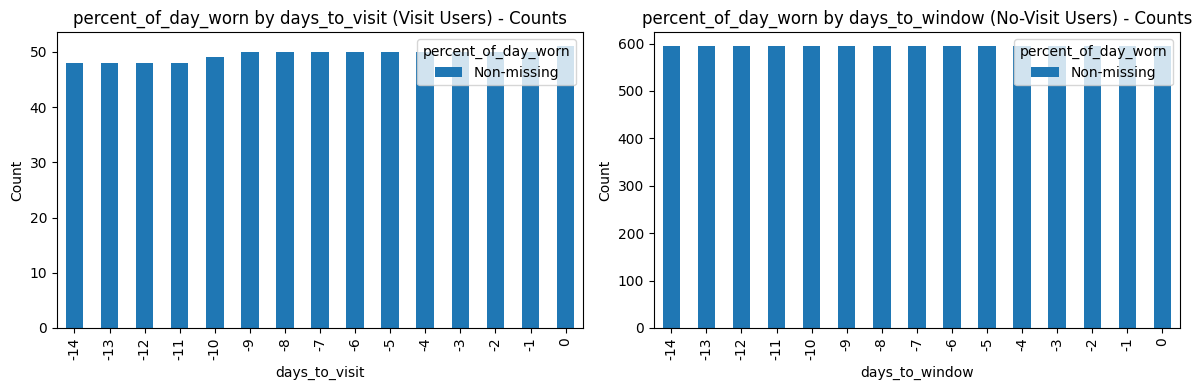

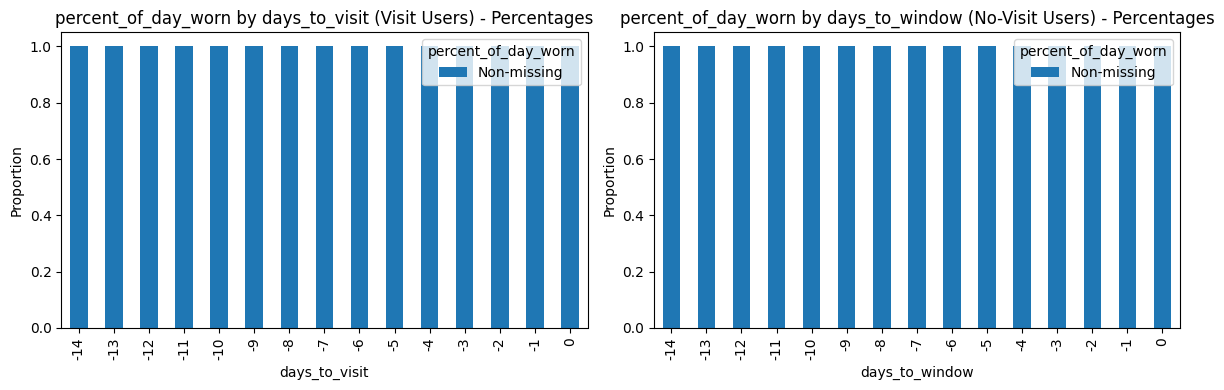

In [173]:
plot_feature_comparison(two_week_visit, two_week, 'percent_of_day_worn', bin_continuous=True)

In [174]:
two_week_visit_app = two_week_visit[two_week_visit['study_group'] != 'No App']
two_week_app = two_week[two_week['study_group'] != 'No App']

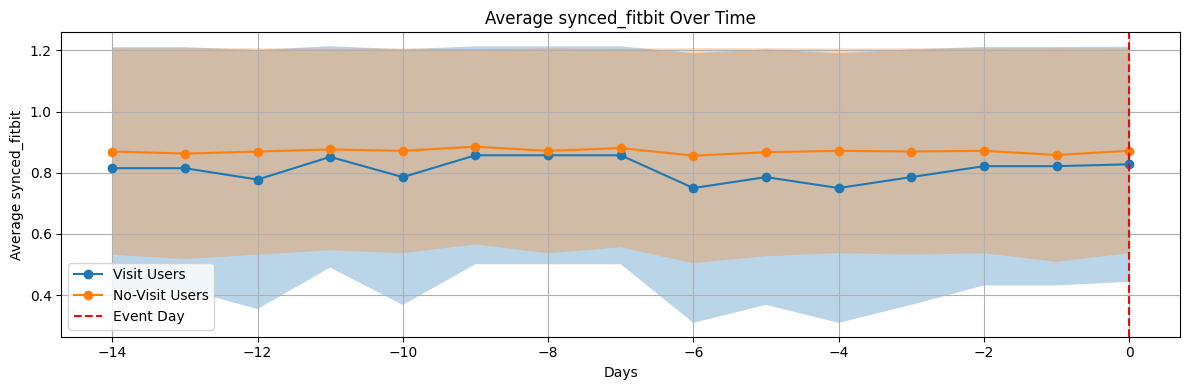

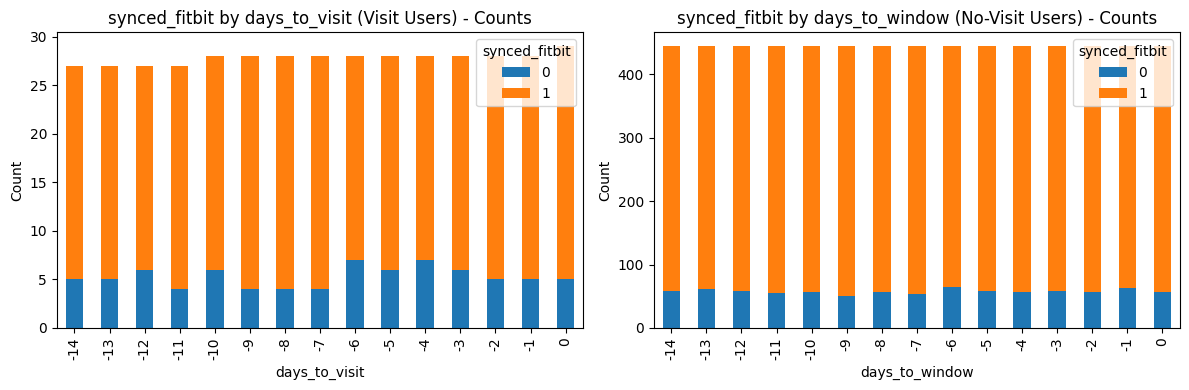

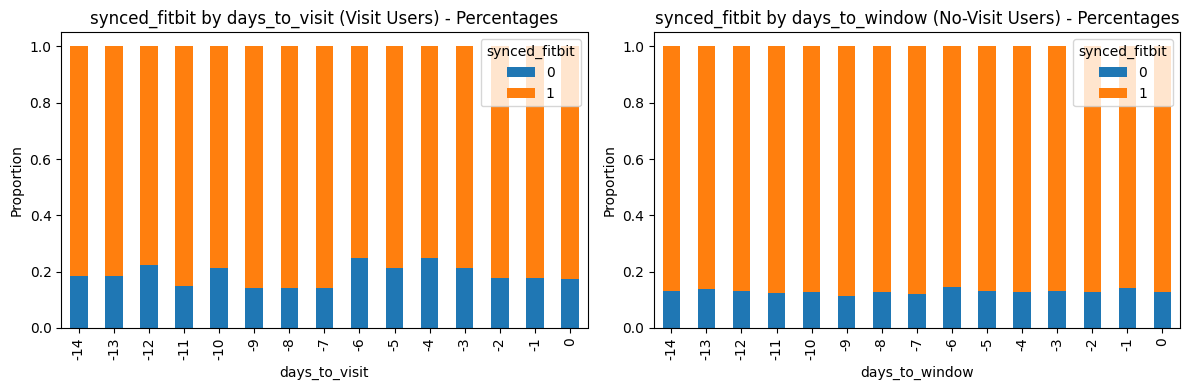

In [175]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'synced_fitbit', bin_continuous=False)

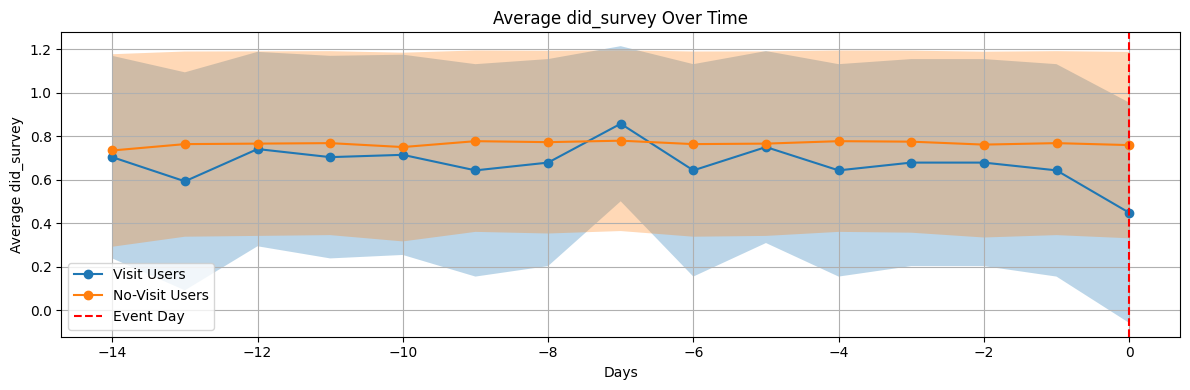

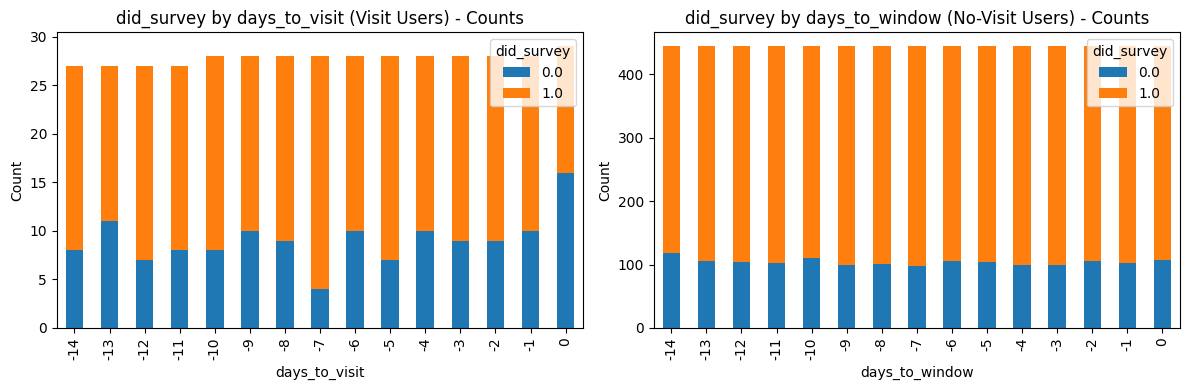

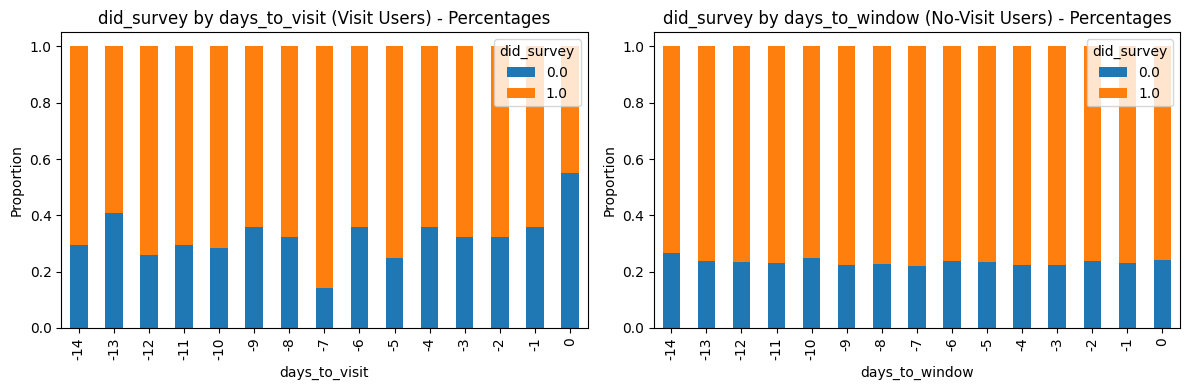

In [176]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'did_survey', bin_continuous=False)

## 3) Additional Things to Try

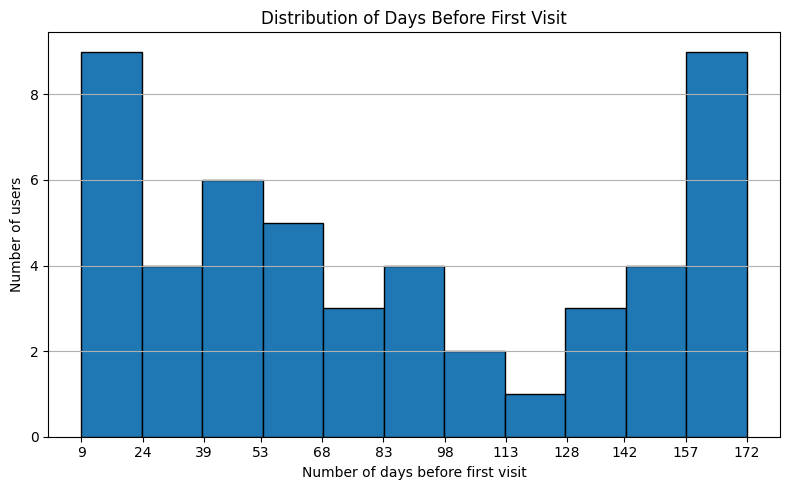

In [52]:
users_with_visit = full_fb_data[full_fb_data['has_visit'] == 1]
first_visit_days = users_with_visit[users_with_visit['visit_day'] == 1].groupby('fitbit_user_id')['days'].min()
merged = users_with_visit.merge(first_visit_days.rename('first_visit_day'), on='fitbit_user_id')
pre_visit = merged[merged['days'] < merged['first_visit_day']]
days_before_counts = pre_visit.groupby('fitbit_user_id').size()
n_bins = 11
min_val, max_val = days_before_counts.min(), days_before_counts.max()
bins = np.linspace(min_val, max_val, n_bins + 1)
plt.figure(figsize=(8, 5))
plt.hist(days_before_counts, bins=bins, edgecolor='black')
plt.xlabel("Number of days before first visit")
plt.ylabel("Number of users")
plt.title("Distribution of Days Before First Visit")
plt.xticks(np.round(bins))  # Rounded ticks for clarity
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [53]:
# checking hr
def check_hr(df, thresh):
  count = 0
  users = []
  user_count = 0

  for user_id, group in df.groupby('fitbit_user_id'):

    for r in group['heart']:

      if r > thresh:
        # print(str(user_id) + ' hr: ' + str(r))
        count += 1

        if user_id not in users:
          users.append(user_id)
          user_count += 1

  return count, user_count, users

In [54]:
check_hr(three_week_visit, 80)

(95, 7, [7, 28, 67, 126, 181, 215, 272])

In [55]:
check_hr(three_week, 80)

(441,
 20,
 [12,
  48,
  74,
  89,
  95,
  99,
  110,
  112,
  115,
  133,
  137,
  162,
  186,
  189,
  210,
  222,
  274,
  287,
  293,
  305])

In [56]:
check_hr(three_week_visit, 70)

(279,
 22,
 [7,
  28,
  32,
  49,
  67,
  103,
  105,
  126,
  156,
  158,
  180,
  181,
  192,
  196,
  198,
  215,
  218,
  227,
  257,
  267,
  272,
  284])

In [57]:
check_hr(three_week, 70)

(2998,
 79,
 [9,
  12,
  14,
  20,
  26,
  31,
  33,
  35,
  36,
  39,
  47,
  48,
  50,
  55,
  56,
  62,
  63,
  74,
  77,
  87,
  89,
  90,
  95,
  99,
  101,
  106,
  110,
  112,
  115,
  123,
  125,
  132,
  133,
  136,
  137,
  142,
  143,
  144,
  145,
  146,
  148,
  157,
  162,
  165,
  167,
  170,
  171,
  173,
  175,
  184,
  186,
  188,
  189,
  191,
  195,
  197,
  199,
  203,
  210,
  219,
  222,
  224,
  229,
  233,
  236,
  239,
  252,
  265,
  266,
  268,
  274,
  278,
  287,
  291,
  293,
  301,
  302,
  303,
  305])

## 4) Looking at Random Visit Windows

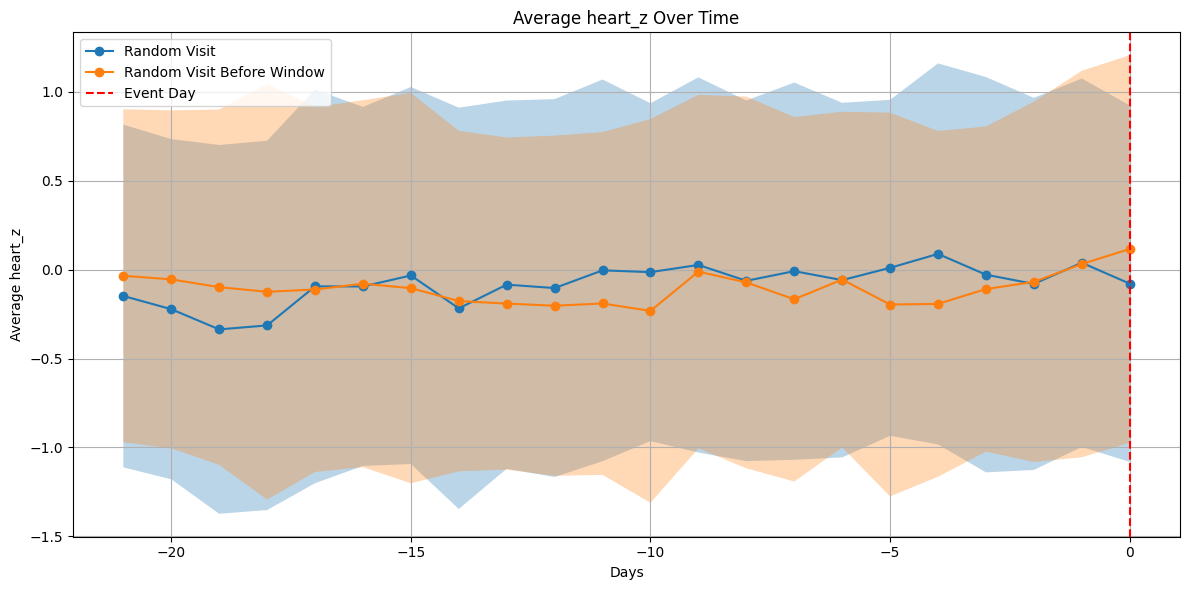

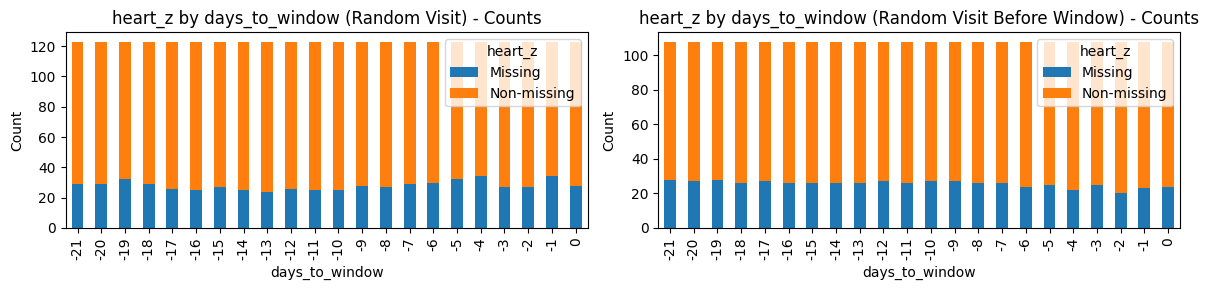

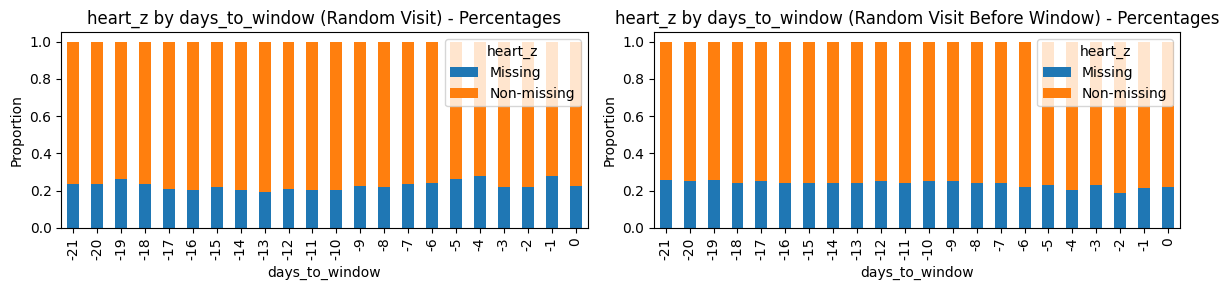

In [210]:
plot_feature_comparison(three_week_visit_random, three_week_visit_random_window, 'heart_z', time_col1='days_to_window', time_col2='days_to_window', label1='Random Visit', label2='Random Visit Before Window', bin_continuous = True)

In [211]:
three_week_visit_heart = drop_nan_user(three_week_visit, 'heart_z')
three_week_heart = drop_nan_user(three_week, 'heart_z')
three_week_visit_random_heart = drop_nan_user(three_week_visit_random, 'heart_z')
three_week_visit_random_window_heart = drop_nan_user(three_week_visit_random_window, 'heart_z')

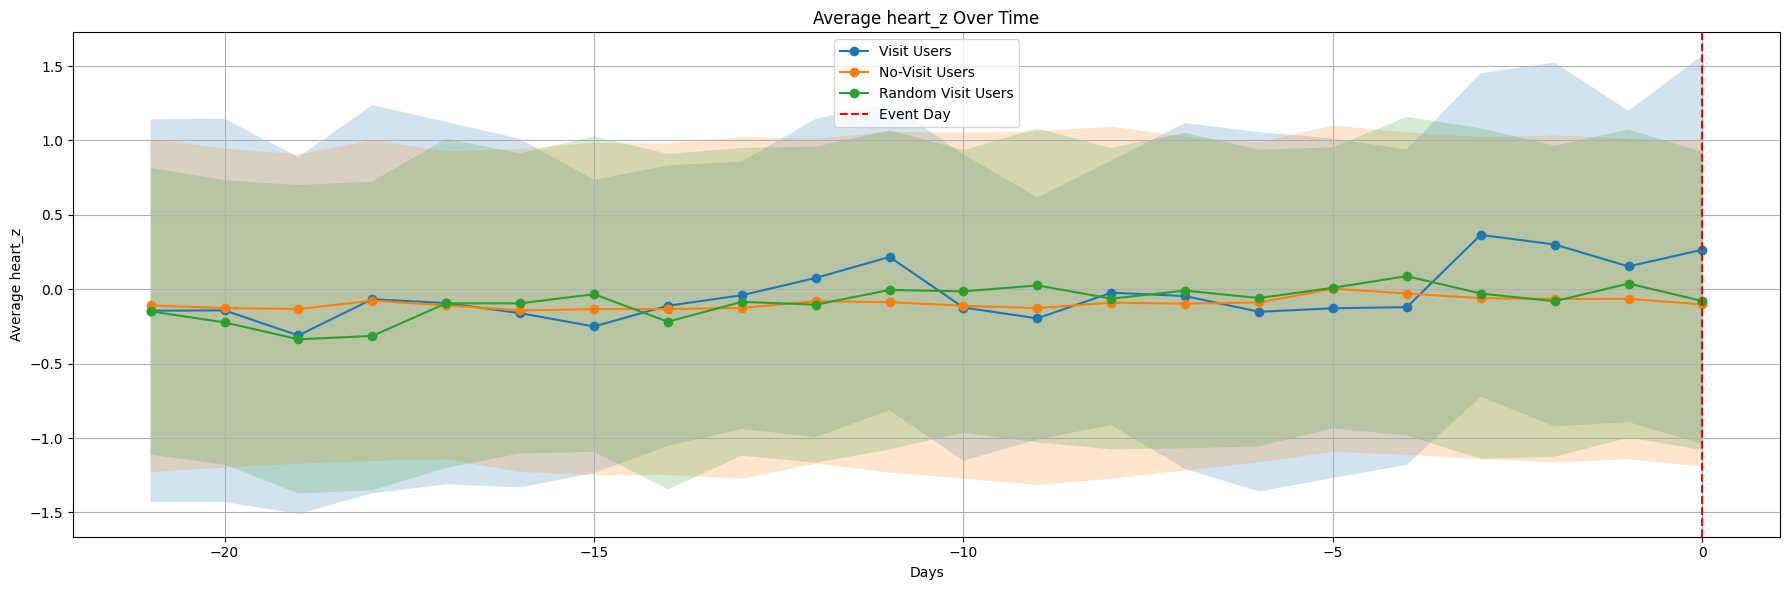

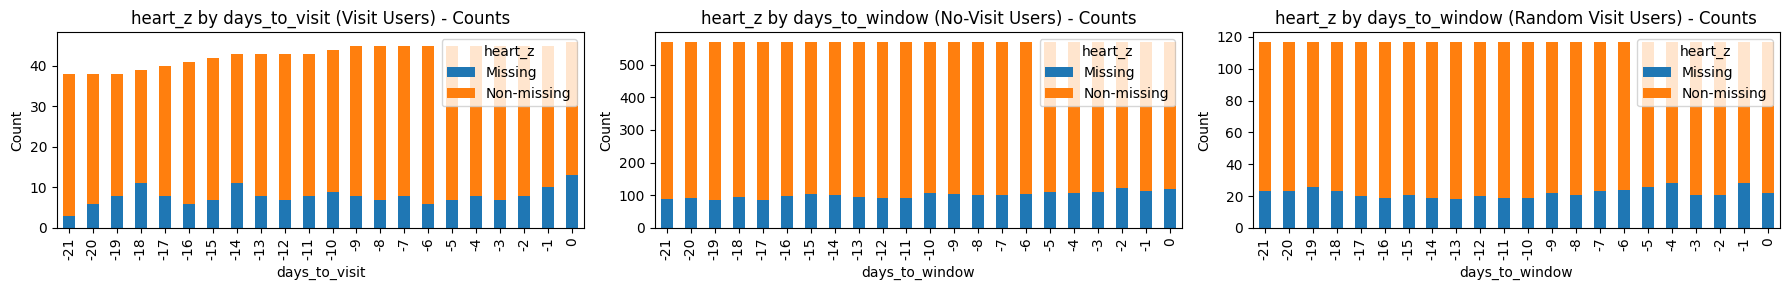

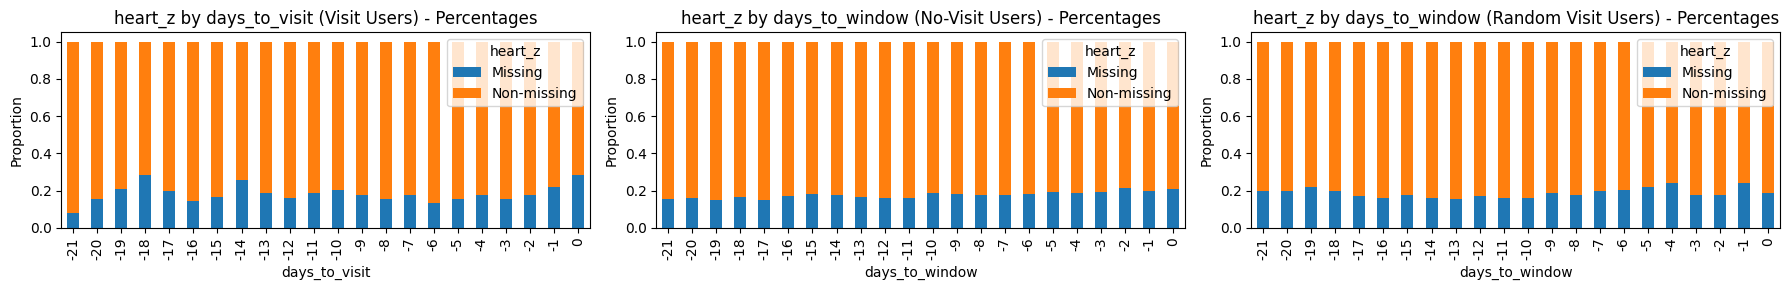

In [254]:
plot_feature_comparison_3(three_week_visit_heart[three_week_visit_heart['fitbit_user_id'] != 82], three_week_heart, three_week_visit_random_heart, 'heart_z', bin_continuous = True)

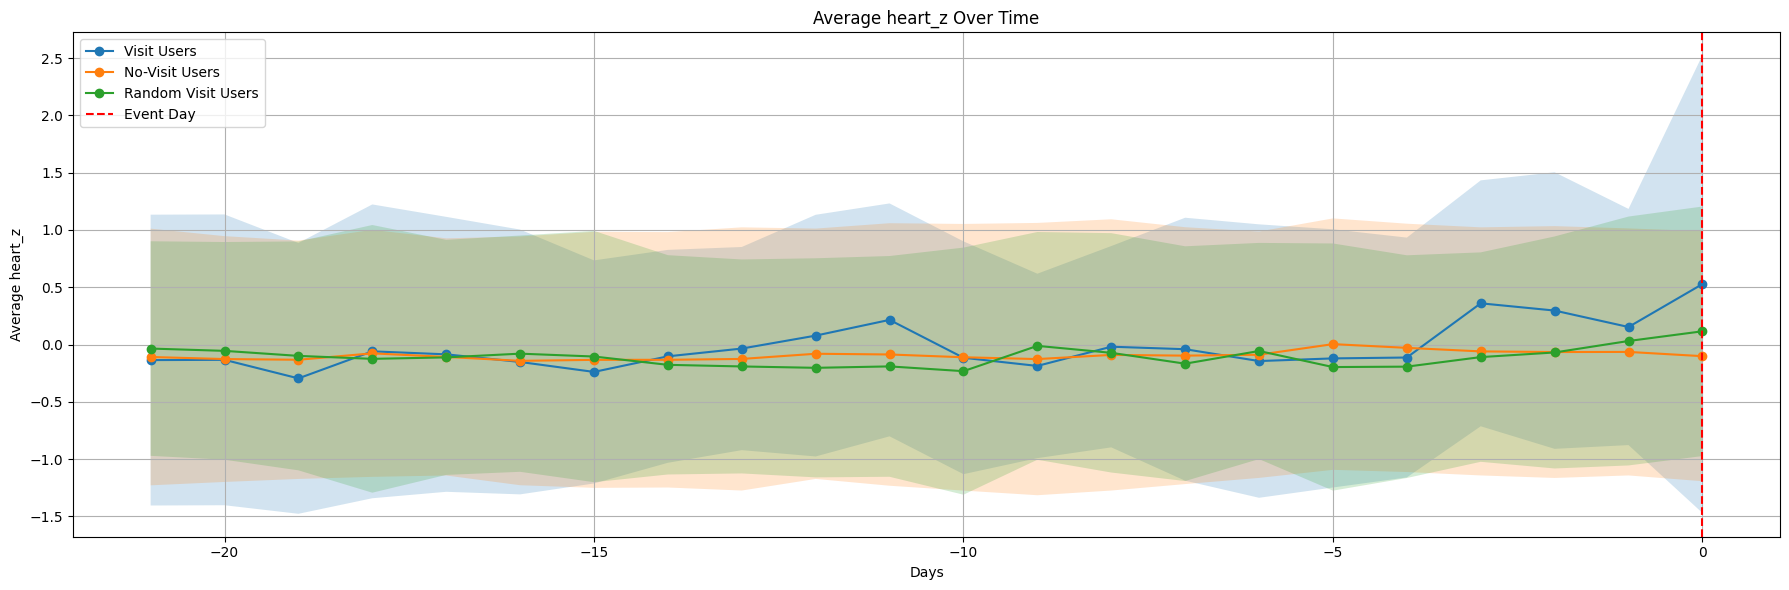

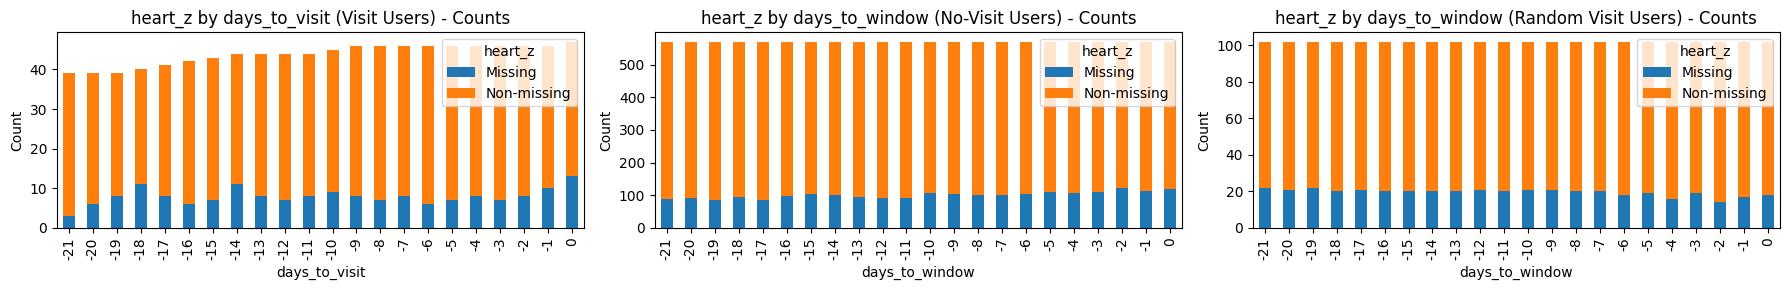

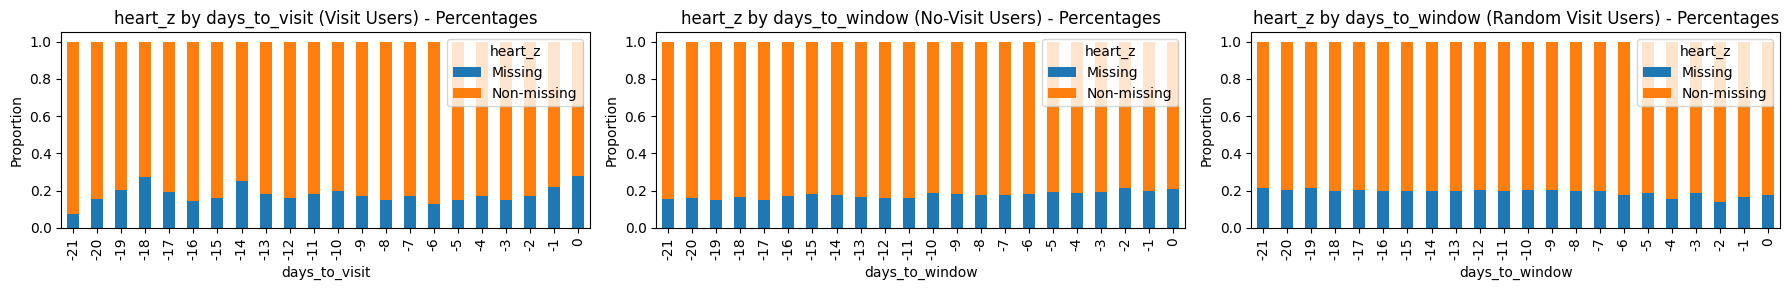

In [213]:
plot_feature_comparison_3(three_week_visit_heart, three_week_heart, three_week_visit_random_window_heart, 'heart_z', bin_continuous = True)

In [214]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')
three_week_visit_random_symptoms = drop_nan_user(three_week_visit_random, 'symptoms')
three_week_visit_random_window_symptoms = drop_nan_user(three_week_visit_random_window, 'symptoms')

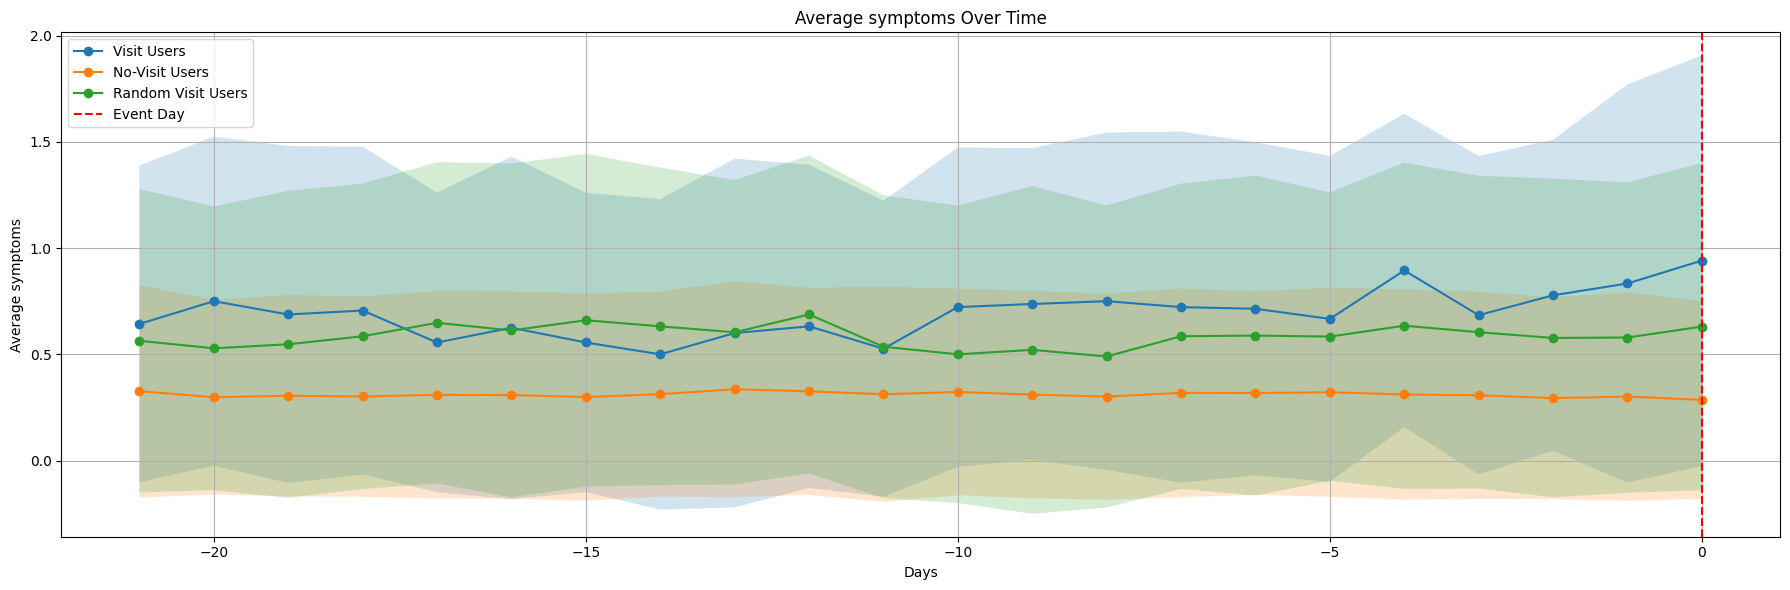

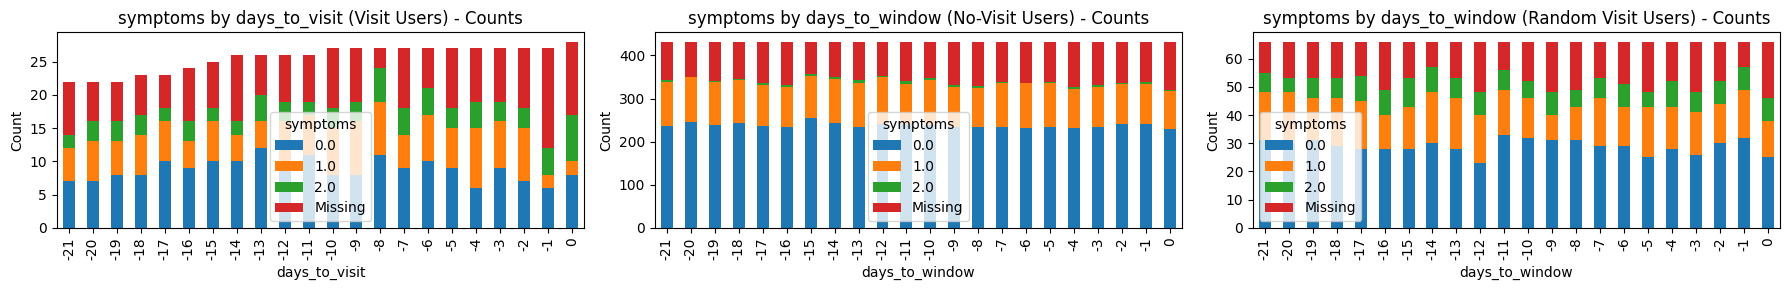

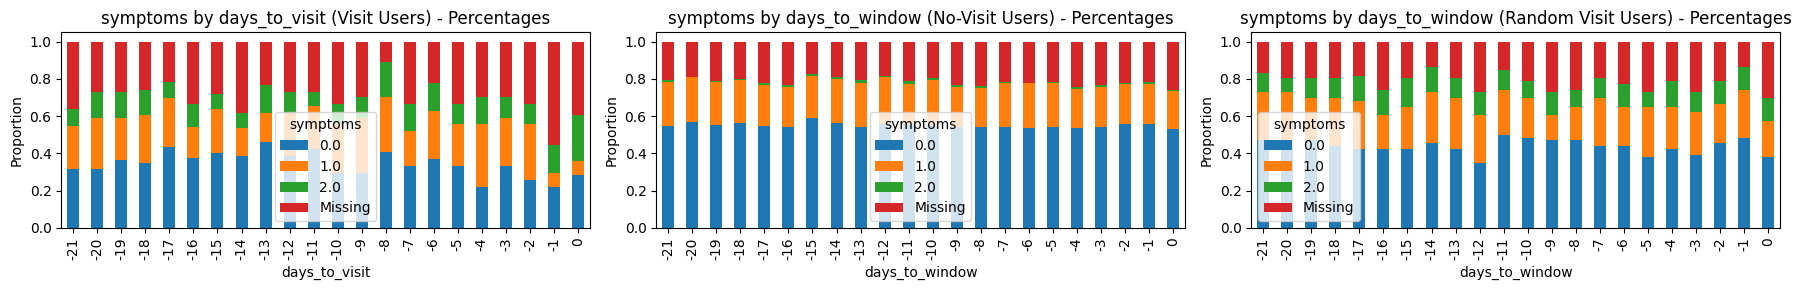

In [215]:
plot_feature_comparison_3(three_week_visit_symptoms, three_week_symptoms, three_week_visit_random_symptoms, 'symptoms', bin_continuous = False)

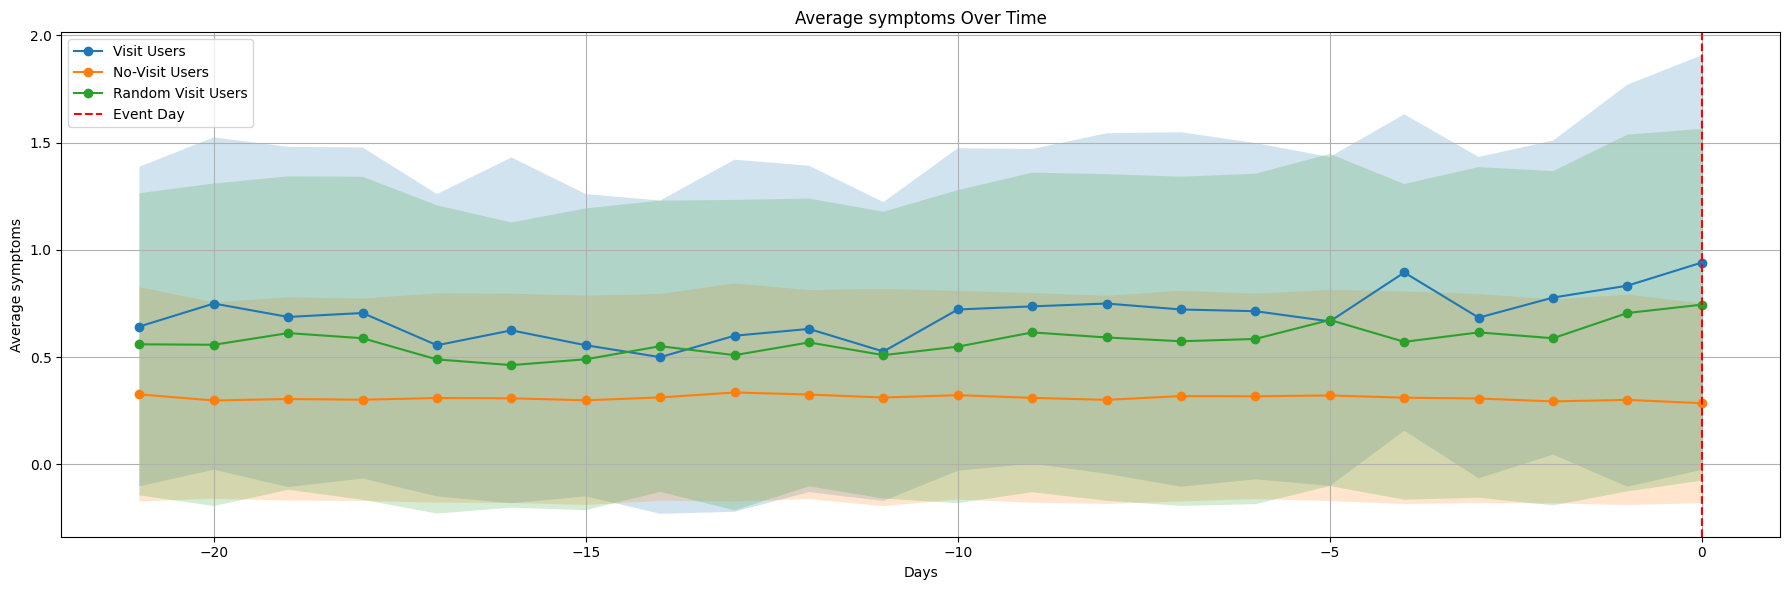

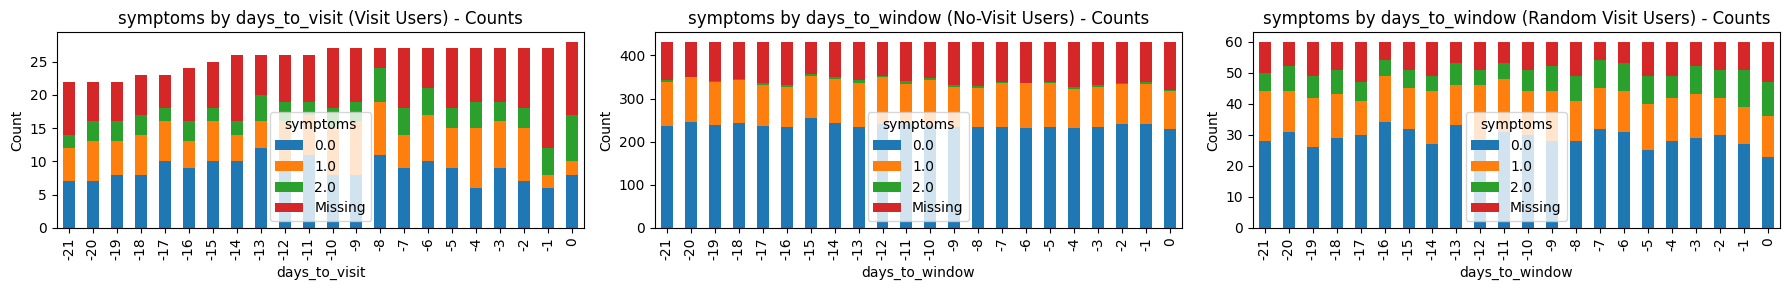

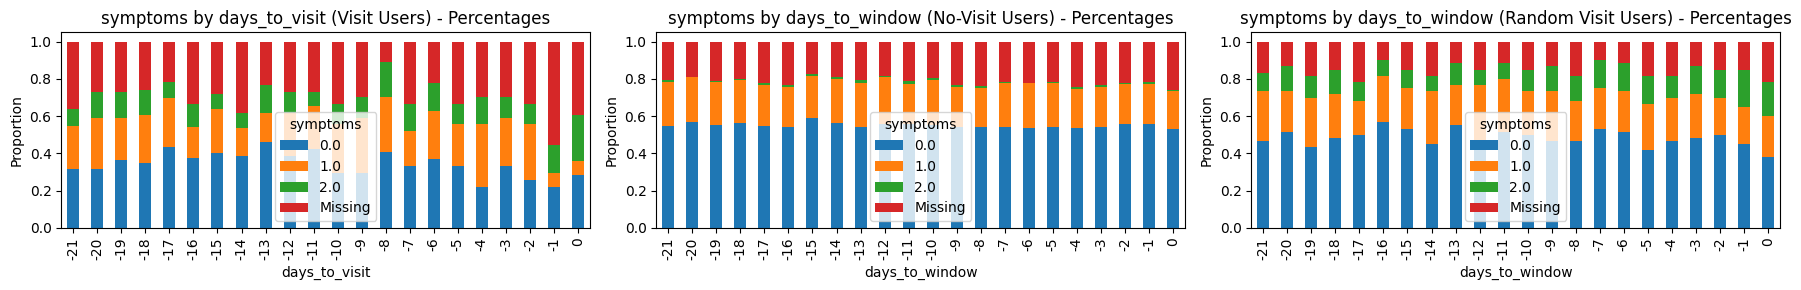

In [216]:
plot_feature_comparison_3(three_week_visit_symptoms, three_week_symptoms, three_week_visit_random_window_symptoms, 'symptoms', bin_continuous = False)

## 5) Focusing in on last 5 days

In [239]:
visit_3wk_subset = three_week_visit[three_week_visit['days_to_visit'].between(-5, 0)]
random_visit_3wk_subset = three_week_visit_random[three_week_visit_random['days_to_window'].between(-5, 0)]
random_window_visit_3wk_subset = three_week_visit_random_window[three_week_visit_random_window['days_to_window'].between(-5, 0)]

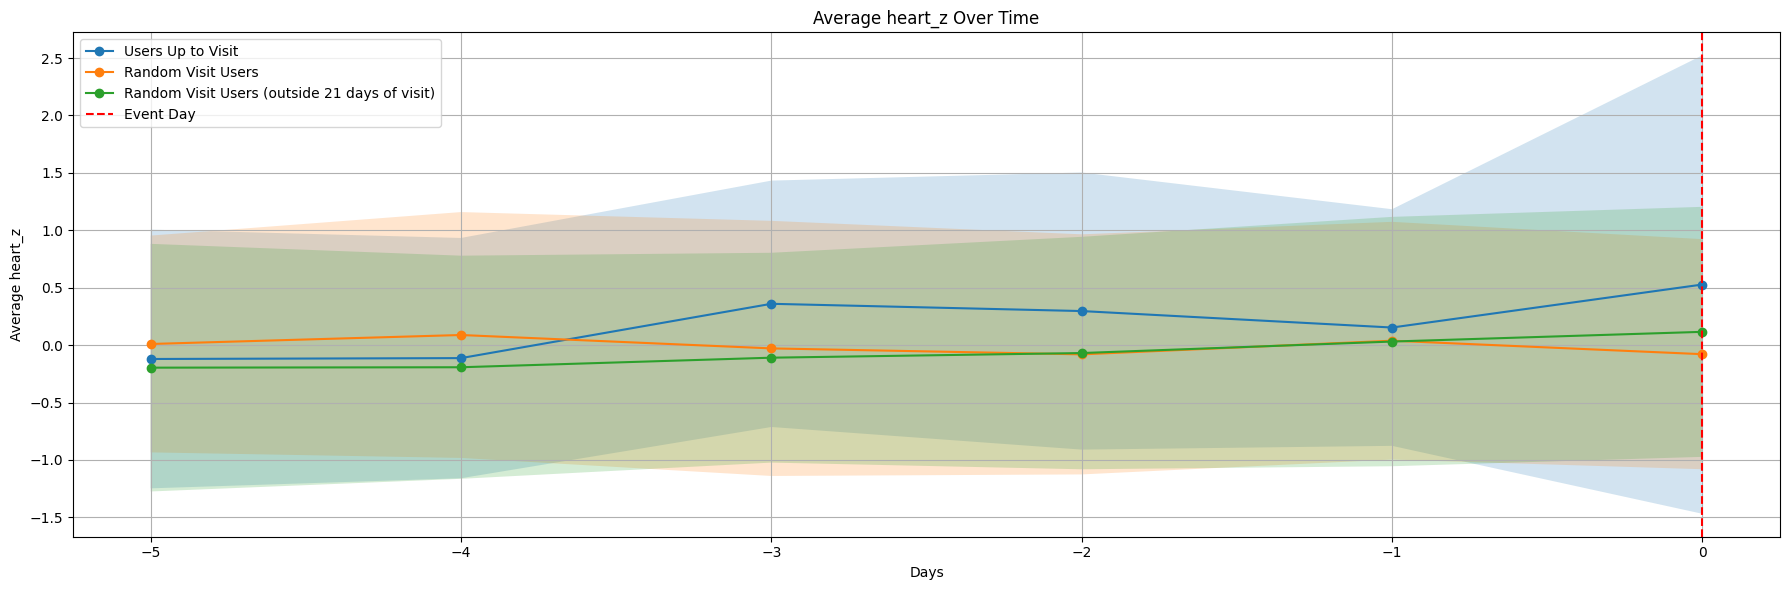

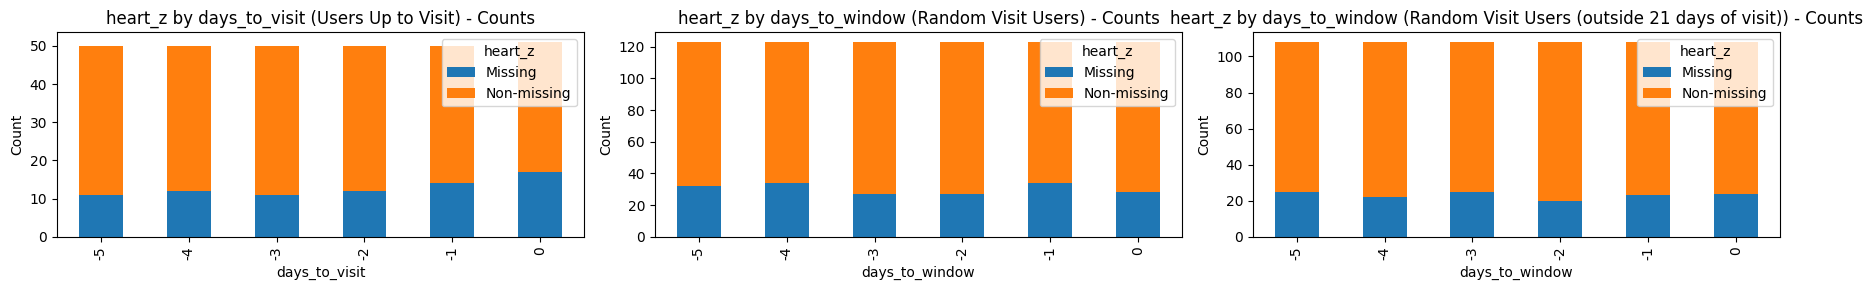

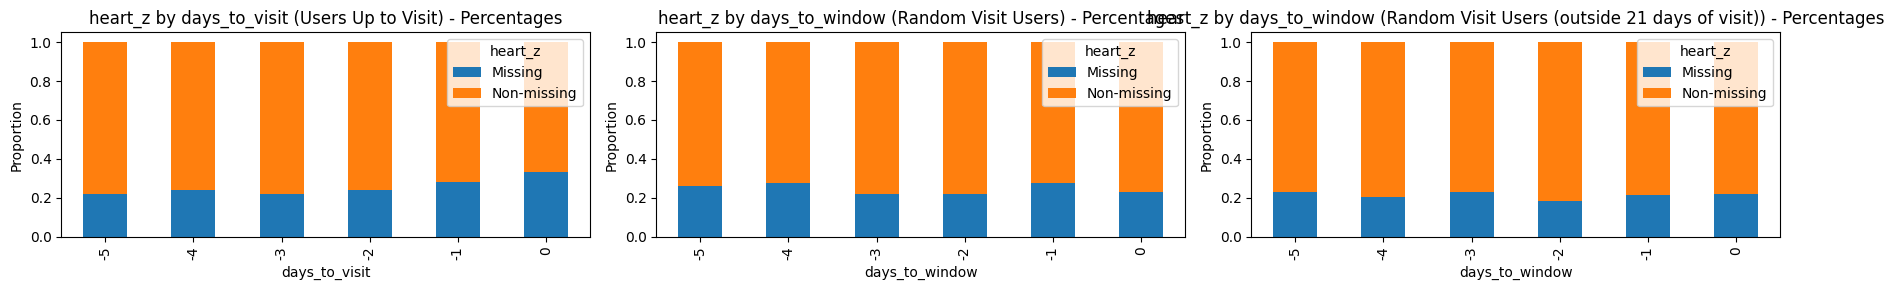

In [241]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'heart_z', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=True)

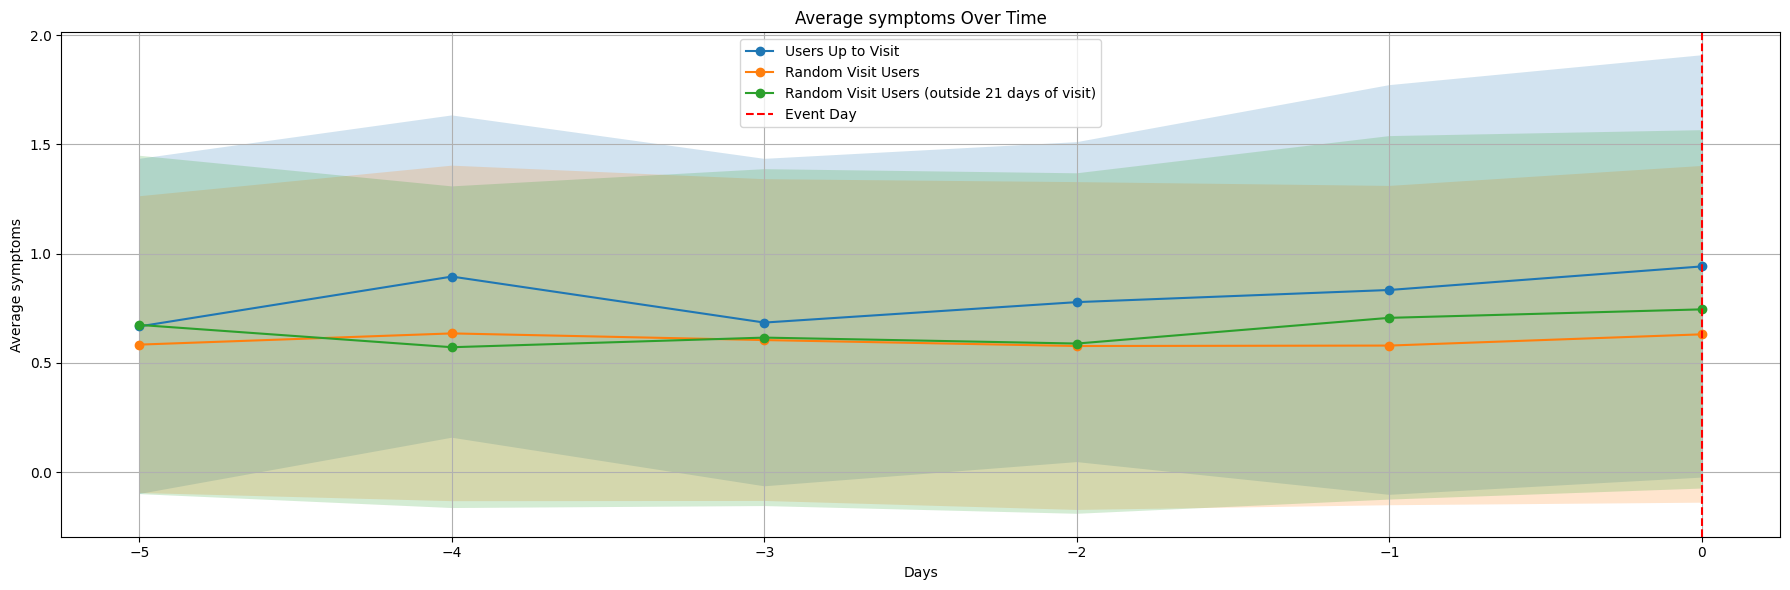

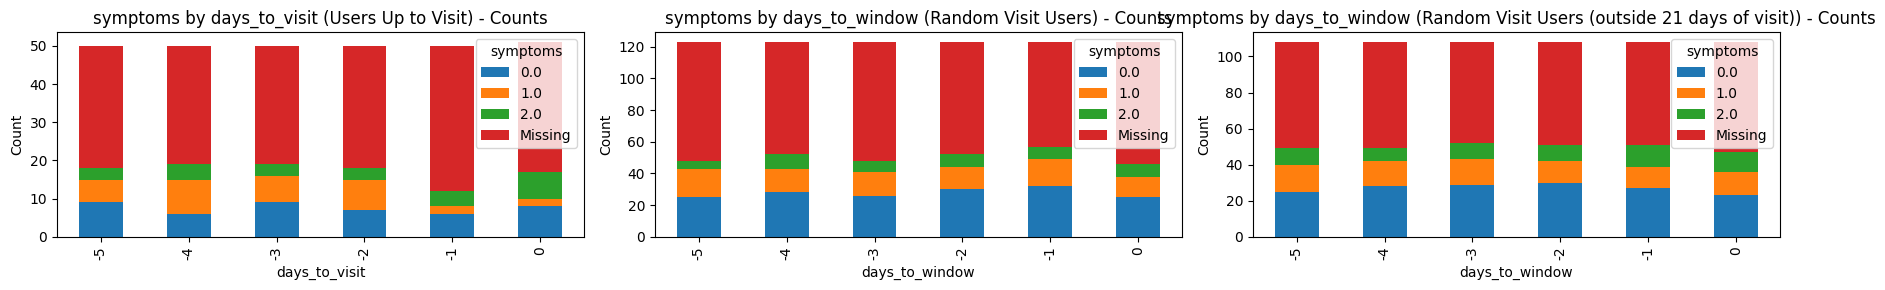

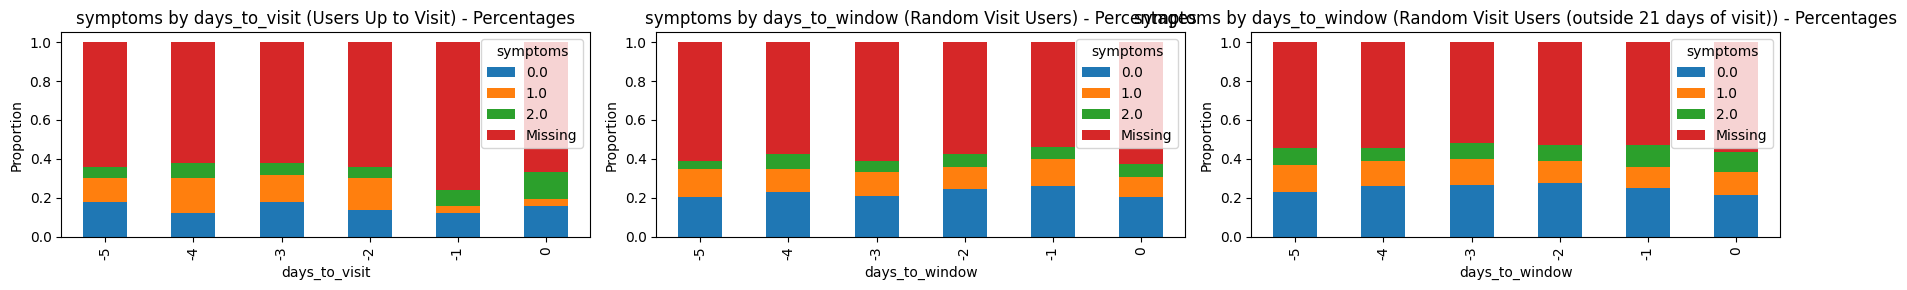

In [242]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'symptoms', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=False)

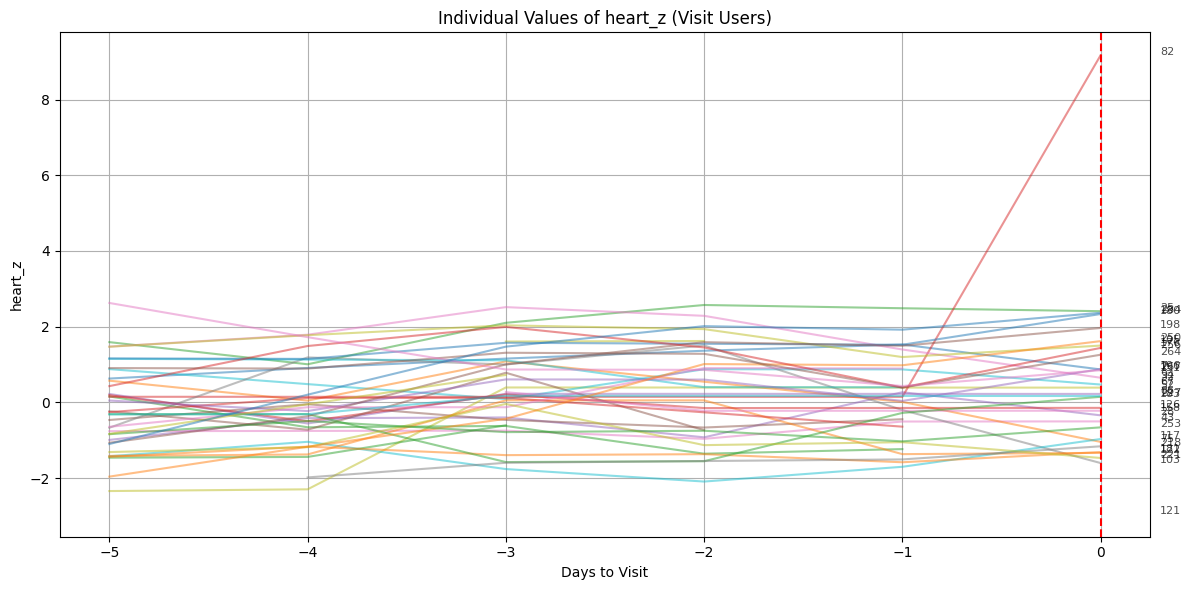

In [249]:
plot_individual_trajectories(visit_3wk_subset, 'heart_z')

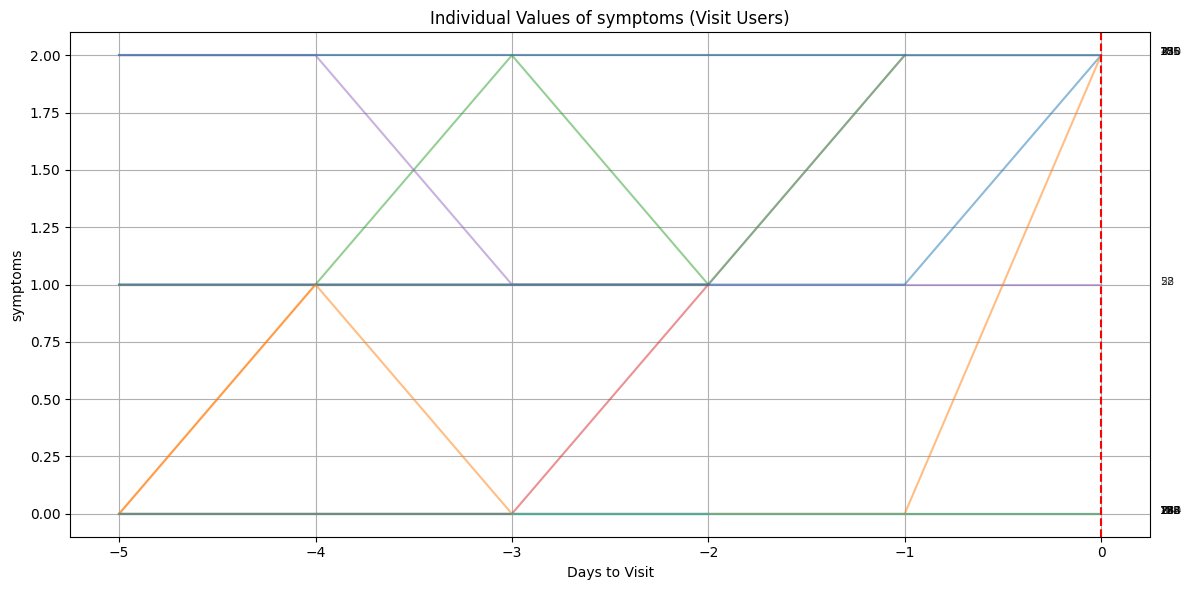

In [252]:
plot_individual_trajectories(visit_3wk_subset, 'symptoms')

In [256]:
visit_3wk_subset = visit_3wk_subset[visit_3wk_subset['fitbit_user_id'] != 82]
random_visit_3wk_subset = random_visit_3wk_subset[random_visit_3wk_subset['fitbit_user_id'] != 82]
random_window_visit_3wk_subset = random_window_visit_3wk_subset[random_window_visit_3wk_subset['fitbit_user_id'] != 82]

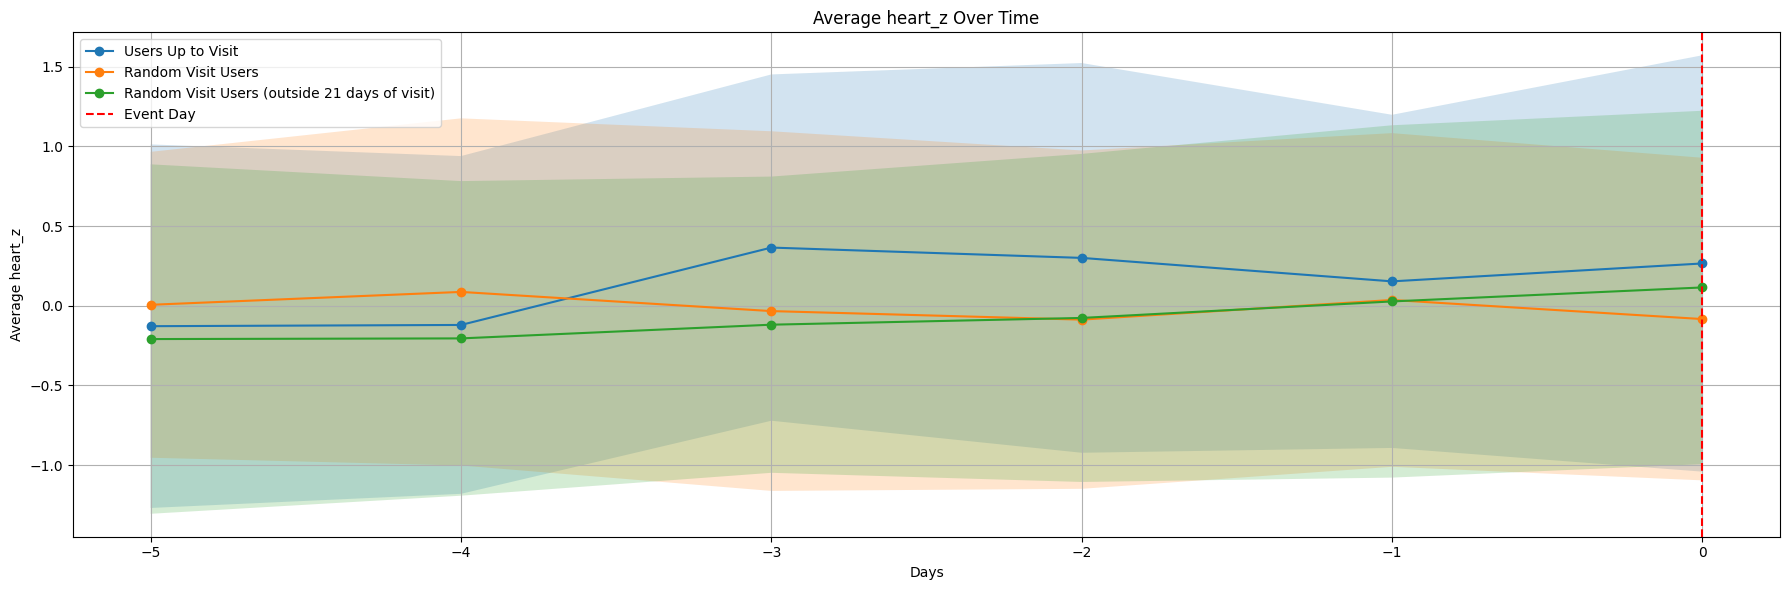

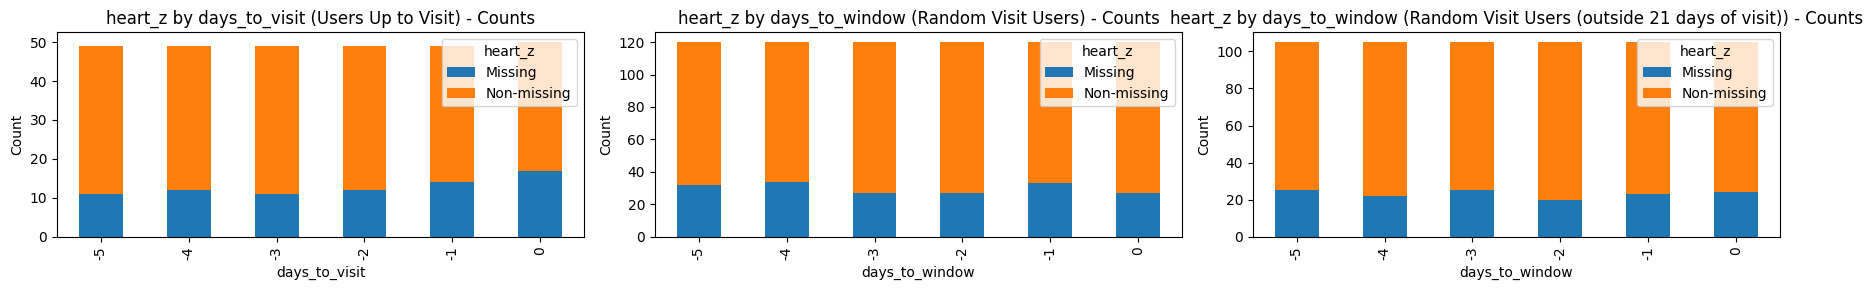

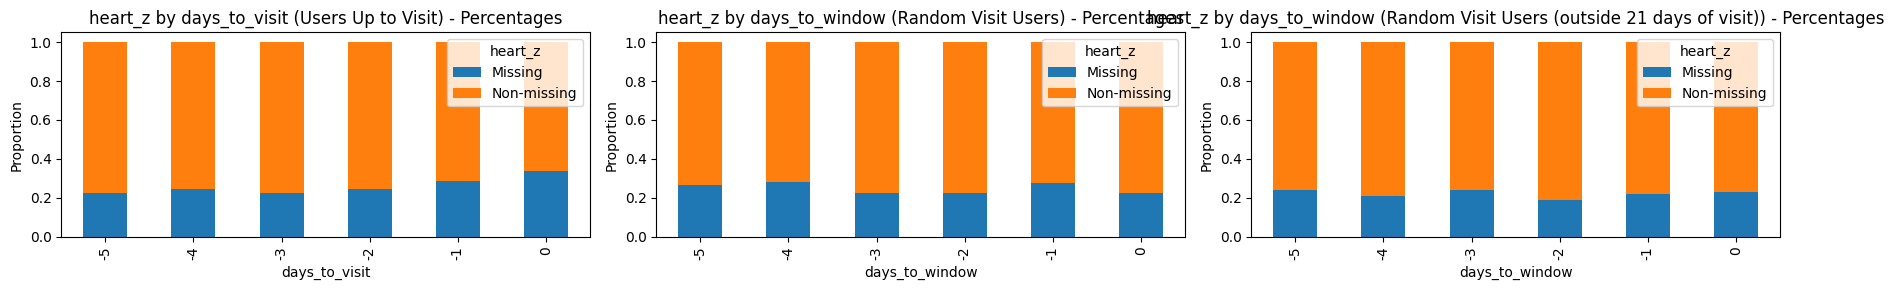

In [257]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'heart_z', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=True)